# Forecasting Adventure Works

### Setup

Abaixo contem a instalação dos pacotes necessários para a execução do notebook, na primeira execução é necessário descomentar o código e executar as celulas

In [1]:
# Caso possua GPU pode instalar a versão do PyTorch com gpu
# !pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu126 -q

# import torch

# print(f"Versão do PyTorch: {torch.__version__}")
# print(f"CUDA está disponível? {torch.cuda.is_available()}")


In [ ]:
# Importação de bibliotecas relacionadas a manipulação de OS 
import sys
import os
import warnings
warnings.filterwarnings("ignore")  # Remoção de warnings

# Importação das bibliotecas relacionadas a manipulação de dados
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)  # Removendo notação cientifica
import numpy as np
from ipywidgets import interact

# Importação das bibliotecas de visualização de dados
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Definindo um tema padrão para as visualizações
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    palette='pastel',
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.titlesize': 'x-large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
    }
)

scatter_kwargs = dict(palette='viridis', alpha=0.8, linewidth=0)

# Importação de bibliotcas estatísticas
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Métricas de avaliação
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, 
    r2_score
)
# Deep learning
import torch

# Funções customizadas
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# função de conexão com databricks e leitura dos dados
from utils.setup import get_connections_and_load_data

# Modelo de deep learning tft
#from utils.models_forecasting_aw import ForecastingModel

In [3]:
# Definindo o device para o PyTorch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Utilizando dispositivo: {device.upper()}")

Utilizando dispositivo: CUDA


## Customs Functions

In [4]:
def removendo_granularidade_cliente(df):
   'Função para remover a granularidade do cliente, agrupando as vendas por dia e produto'
   df_final = []

   lojas = set(df['name_store'])

   for loja in lojas:
      df_loja = df[df['name_store'] == loja]
      df_agrupado = df_loja.groupby(['order_date_dt', 'fk_product']).agg(
         order_qty=('order_qty', 'sum'),
         unit_price=('unit_price', 'mean'),
         selling_price=('selling_price', 'mean'),
         standard_cost=('standard_cost', 'mean')
      ).reset_index()

      df_agrupado = df_agrupado[df_agrupado['order_qty'] > 0]
      df_agrupado['name_store'] = loja

      df_final.append(df_agrupado)
   return pd.concat(df_final, ignore_index=True)

   
# Função para visualizar estacionaridade
def visualiza_estacionaridade(dados_serie):
    '''
    Função para visualizar a estacionaridade de uma série temporal.
    '''
    rolling_mean = dados_serie.rolling(12).mean()
    rolling_std = dados_serie.rolling(12).std()
    
    # Plot
    fig = plt.figure(figsize = (12,6))
    time_series = plt.plot(dados_serie, label = 'Itens Vendidos')
    mean = plt.plot(rolling_mean, color = 'yellow', label = "Média Móvel")
    std = plt.plot(rolling_std, color = 'green', label = "Desvio Padrão Móvel")
    
    plt.legend(loc = 'best')
    plt.title("Visualizando a Estacionaridade")
    plt.xticks([]) 
    plt.yticks([]) 
    plt.show()

Funções usadas com decorador interact

In [5]:
def view_prediction(lojas, produtos, df_merged):
    # Selecionando loja e produto
    store_to_plot = lojas
    product_to_plot = produtos

    # Filtrando o DataFrame para o produto/loja específico
    df_plot = df_merged.reset_index()
    df_plot = df_plot[
        (df_plot['name_store'] == store_to_plot) &
        (df_plot['name_product'] == product_to_plot)
    ]

    plt.figure(figsize=(10, 6))
    # Plotando a linha de dados reais
    sns.lineplot(
        data=df_plot[df_plot['order_date_dt'] <= max_date],
        x='order_date_dt',
        y='order_qty',
        label='Dados Reais',
        color='royalblue',
        marker='o',
        linewidth=2.5
    )

    #  Plotando a linha de Média Móvel (dados históricos)
    sns.lineplot(
        data=df_plot[df_plot['order_date_dt'] <= max_date],
        x='order_date_dt',
        y='previsao_demanda',
        label='Média Móvel (Histórico)',
        color='darkorange',
        linestyle='--'
    )

    # Plotando a linha da previsão usando Médias Móveis)
    sns.lineplot(
        data=df_plot[df_plot['order_date_dt'] >= max_date],
        x='order_date_dt',
        y='previsao_demanda',
        label='Previsão com Média Móvel (futuro)',
        color='green',
        linestyle='--'
    )

    # Configurando títulos e legendas
    plt.title(f'Previsão de Demanda vs. Dados Reais\nProduto: {product_to_plot} | Loja: {store_to_plot}', fontsize=16)
    plt.xlabel('Data', fontsize=12)
    plt.ylabel('Quantidade Vendida', fontsize=12)
    plt.legend(title='Legenda')
    plt.xticks(rotation=45)
    plt.tight_layout() 
    plt.show()


## Load Data

### Dicionário de dados.

| Campo                  | Tipo de Dado | Descrição |
|------------------------|--------------|-----------|
| `pk_sales_order_detail` | Inteiro      | Identificador único do item de pedido de venda. |
| `fk_product`           | Inteiro      | Chave estrangeira que referencia o produto vendido. |
| `order_date_dt`        | Data         | Data em que o pedido foi realizado. |
| `order_qty`            | Inteiro      | Quantidade de itens vendidos no pedido. |
| `unit_price`           | Numérico     | Preço unitário do produto no momento da venda. |
| `standard_cost`        | Numérico     | Custo padrão do produto. |
| `selling_price`        | Numérico     | Preço de venda aplicado ao produto (considerando descontos e ajustes). |
| `total_due`            | Numérico     | Valor total pago pelo cliente (incluindo impostos e frete). |
| `name_store`           | Texto        | Nome da loja associada à venda (pode ser nulo para vendas online). |
| `name_product`         | Texto        | Nome do produto vendido. |
| `product_category_name`| Texto        | Categoria principal do produto. |
| `sub_category_name`    | Texto        | Subcategoria do produto. |
| `product_line_name`    | Texto        | Linha de produto à qual pertence o item. |
| `product_class_name`   | Texto        | Classificação do produto. |
| `is_manufactured`      | Booleano     | Indica se o produto é fabricado internamente (`true`) ou adquirido de terceiros (`false`). |
| `country_region_code`  | Texto        | Código do país/região da venda. |
| `territory_group`      | Texto        | Agrupamento de territórios de vendas. |


In [6]:
# Query para carregamento do dataset
query = '''
    select
        pk_sales_order_detail
        , fk_product
        , order_date_dt
        , order_qty
        , unit_price
        , standard_cost
        , selling_price
        , total_due
        , name_store
        , name_product
        , product_category_name
        , sub_category_name
        , product_line_name
        , product_class_name
        , is_manufactured
        , country_region_code
        , territory_group
    from ted_dev.marts.fact_sales_forecast
'''
# Carregamento do dataset em um dataframe pandas e exibição inicial dos dados
df = get_connections_and_load_data(query)
df.head()

,pk_sales_order_detail,fk_product,order_date_dt,order_qty,unit_price,standard_cost,selling_price,total_due,name_store,name_product,product_category_name,sub_category_name,product_line_name,product_class_name,is_manufactured,country_region_code,territory_group
0,1,776,2011-05-31,1,2024.99,1898.09,3374.99,23153.23,Better Bike Shop,"Mountain-100 Black, 42",Bikes,Mountain Bikes,Mountain,High,True,US,North America
1,2,777,2011-05-31,3,2024.99,1898.09,3374.99,23153.23,Better Bike Shop,"Mountain-100 Black, 44",Bikes,Mountain Bikes,Mountain,High,True,US,North America
2,3,778,2011-05-31,1,2024.99,1898.09,3374.99,23153.23,Better Bike Shop,"Mountain-100 Black, 48",Bikes,Mountain Bikes,Mountain,High,True,US,North America
3,4,771,2011-05-31,1,2039.99,1912.15,3399.99,23153.23,Better Bike Shop,"Mountain-100 Silver, 38",Bikes,Mountain Bikes,Mountain,High,True,US,North America
4,5,772,2011-05-31,1,2039.99,1912.15,3399.99,23153.23,Better Bike Shop,"Mountain-100 Silver, 42",Bikes,Mountain Bikes,Mountain,High,True,US,North America


## Análise Descritiva

In [7]:
# Informações gerais dos dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121317 entries, 0 to 121316
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   pk_sales_order_detail  121317 non-null  int64  
 1   fk_product             121317 non-null  int64  
 2   order_date_dt          121317 non-null  object 
 3   order_qty              121317 non-null  int64  
 4   unit_price             121317 non-null  float64
 5   standard_cost          121317 non-null  float64
 6   selling_price          121317 non-null  float64
 7   total_due              121317 non-null  float64
 8   name_store             60919 non-null   object 
 9   name_product           121317 non-null  object 
 10  product_category_name  121317 non-null  object 
 11  sub_category_name      121317 non-null  object 
 12  product_line_name      121317 non-null  object 
 13  product_class_name     121317 non-null  object 
 14  is_manufactured        121317 non-nu

Observa-se a presença de valores ausentes na coluna `name_store`, ocasionados por vendas realizadas no canal online.

Também identifiquei que alguns campos apresentam tipagem incorreta. deste modo efetuei a correção abaixo.

**Preenchendo valores nulos**

In [8]:
# Preenchendo valores nulos com tag do canal de vendas online
df['name_store'].fillna('online_sales', inplace=True)


**Correção da tipagem dos dados**

In [9]:
# Features numéricas
float_cols = ['standard_cost', 'selling_price', 'total_due']

for col in float_cols:
    df[col] = df[col].astype('float')

# Features categoricas
categoric_cols = [
  'fk_product',
  'name_store',
  'product_category_name',
  'sub_category_name',
  'product_line_name',
  'product_class_name',
  'country_region_code',
  'territory_group',
  'is_manufactured'
]

for col in categoric_cols:
    df[col] = df[col].astype(str).astype('category')


# Features data
df['order_date_dt'] = pd.to_datetime(df['order_date_dt'])

In [10]:
df.head()

,pk_sales_order_detail,fk_product,order_date_dt,order_qty,unit_price,standard_cost,selling_price,total_due,name_store,name_product,product_category_name,sub_category_name,product_line_name,product_class_name,is_manufactured,country_region_code,territory_group
0,1,776,2011-05-31,1,2024.99,1898.09,3374.99,23153.23,Better Bike Shop,"Mountain-100 Black, 42",Bikes,Mountain Bikes,Mountain,High,True,US,North America
1,2,777,2011-05-31,3,2024.99,1898.09,3374.99,23153.23,Better Bike Shop,"Mountain-100 Black, 44",Bikes,Mountain Bikes,Mountain,High,True,US,North America
2,3,778,2011-05-31,1,2024.99,1898.09,3374.99,23153.23,Better Bike Shop,"Mountain-100 Black, 48",Bikes,Mountain Bikes,Mountain,High,True,US,North America
3,4,771,2011-05-31,1,2039.99,1912.15,3399.99,23153.23,Better Bike Shop,"Mountain-100 Silver, 38",Bikes,Mountain Bikes,Mountain,High,True,US,North America
4,5,772,2011-05-31,1,2039.99,1912.15,3399.99,23153.23,Better Bike Shop,"Mountain-100 Silver, 42",Bikes,Mountain Bikes,Mountain,High,True,US,North America


In [11]:
# Colunas numéricas
numeric_cols = ['order_qty', 'unit_price','standard_cost','selling_price','total_due']

# Exibição da estatística descritiva dos dados
df[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
order_qty,121317.00,2.27,2.49,1.00,1.00,1.00,3.00,44.00
unit_price,121317.00,465.09,751.89,1.33,21.49,49.99,602.35,3578.27
standard_cost,121317.00,373.69,554.11,0.86,9.16,38.49,486.71,2171.29
selling_price,121317.00,633.67,931.17,2.29,24.49,63.50,782.99,3578.27
total_due,121317.00,24126.63,32173.50,1.52,623.75,2785.52,41890.97,187487.83


In [12]:
# Dados Duplicados
df[df.duplicated(keep = False)]

,pk_sales_order_detail,fk_product,order_date_dt,order_qty,unit_price,standard_cost,selling_price,total_due,name_store,name_product,product_category_name,sub_category_name,product_line_name,product_class_name,is_manufactured,country_region_code,territory_group


In [13]:
# Contagem de duplicados pela chave primaria
df['pk_sales_order_detail'].duplicated().sum()

np.int64(0)

Como o objetivo é analisar a quantidade de produtos vendidos por loja, é necessário remover a granularidade por cliente, já que uma mesma loja pode ser frequentada por diversos clientes no mesmo dia.

In [14]:
# Contagem de vendas por dia e por loja
df.groupby(['order_date_dt', 'name_store'])\
      .agg(purchases_count=('pk_sales_order_detail', 'nunique'))\
          .reset_index()\
              .query("purchases_count > 0")


,order_date_dt,name_store,purchases_count
22,2011-05-31,Area Bike Accessories,15
28,2011-05-31,Basic Bike Company,11
33,2011-05-31,Better Bike Shop,12
43,2011-05-31,Bike Dealers Association,28
48,2011-05-31,Bike Rims Company,21
...,...,...,...
710079,2014-06-26,online_sales,65
710713,2014-06-27,online_sales,82
711347,2014-06-28,online_sales,68
711981,2014-06-29,online_sales,61


**Removevendo a granularidade de cliente**

In [15]:
# Aplicando a remoção de granularidade de clientes para obter a quantidade de produtos vendidos por loja
df_grouped = removendo_granularidade_cliente(df)
df_grouped.head()

,order_date_dt,fk_product,order_qty,unit_price,selling_price,standard_cost,name_store
0,2012-07-31,759,2,469.79,782.99,486.71,Fitness Hotel
1,2012-07-31,769,1,469.79,782.99,486.71,Fitness Hotel
2,2012-07-31,827,3,165.23,275.38,122.27,Fitness Hotel
3,2012-07-31,839,1,780.82,1431.50,868.63,Fitness Hotel
4,2012-10-30,727,1,202.33,337.22,187.16,Fitness Hotel


In [16]:
# Obtendo metadados das vendas
product_metadata = df.drop_duplicates(subset=['fk_product'])[[
    'fk_product', 'name_product', 'product_category_name', 'sub_category_name',
    'product_line_name', 'product_class_name', 'is_manufactured',
    'country_region_code', 'territory_group'
]]

# Juntamos os metadados ao DataFrame agregado
df_processed = pd.merge(df_grouped, product_metadata, on='fk_product', how='left')
df_processed.head()

,order_date_dt,fk_product,order_qty,unit_price,selling_price,standard_cost,name_store,name_product,product_category_name,sub_category_name,product_line_name,product_class_name,is_manufactured,country_region_code,territory_group
0,2012-07-31,759,2,469.79,782.99,486.71,Fitness Hotel,"Road-650 Red, 58",Bikes,Road Bikes,Road,Low,True,US,North America
1,2012-07-31,769,1,469.79,782.99,486.71,Fitness Hotel,"Road-650 Black, 48",Bikes,Road Bikes,Road,Low,True,US,North America
2,2012-07-31,827,3,165.23,275.38,122.27,Fitness Hotel,ML Road Rear Wheel,Components,Wheels,Road,Medium,True,US,North America
3,2012-07-31,839,1,780.82,1431.50,868.63,Fitness Hotel,"HL Road Frame - Black, 48",Components,Road Frames,Road,High,True,US,North America
4,2012-10-30,727,1,202.33,337.22,187.16,Fitness Hotel,"LL Road Frame - Red, 52",Components,Road Frames,Road,Low,True,CA,North America


In [17]:
# Adicionando o valor total de vendas
df_processed['total_sales'] = df_processed['unit_price'] * df_processed['order_qty']

In [18]:
# Correlação entre as variáveis continuas
numeric_colums = [
    'order_qty',
    'unit_price',
    'selling_price',
    'standard_cost',
    'total_sales'
]

df_processed[numeric_colums].corr()

,order_qty,unit_price,selling_price,standard_cost,total_sales
order_qty,1.00,-0.24,-0.21,-0.21,0.15
unit_price,-0.24,1.00,0.94,0.94,0.67
selling_price,-0.21,0.94,1.00,1.00,0.74
standard_cost,-0.21,0.94,1.00,1.00,0.73
total_sales,0.15,0.67,0.74,0.73,1.00


In [19]:
# Analise quantitativa
print(f"""                                  Produtos
      =================================================================
      Quantidade total de produtos distintos: {df_processed['name_product'].nunique()}
      Quantidade total de categorias de produtos distintos: {df_processed['product_category_name'].nunique()}
      Quantidade total de sub-categorias de produtos distintos: {df_processed['sub_category_name'].nunique()}
      Quantidade total de linhas de produtos distintos: {df_processed['product_line_name'].nunique()}
      Quantidade total de classes de produtos distintos: {df_processed['product_class_name'].nunique()}

                        Lojas e Região de Vendas
      =================================================================
      Quantidade total de lojas distintas: {df_processed['name_store'].nunique()}
      Quantidade total de países distintos: {df_processed['country_region_code'].nunique()}
      Quantidade total de zonas comerciais distintas: {df_processed['territory_group'].nunique()}
      """)



                                  Produtos
      Quantidade total de produtos distintos: 266
      Quantidade total de categorias de produtos distintos: 4
      Quantidade total de sub-categorias de produtos distintos: 35
      Quantidade total de linhas de produtos distintos: 5
      Quantidade total de classes de produtos distintos: 4

                        Lojas e Região de Vendas
      Quantidade total de lojas distintas: 634
      Quantidade total de países distintos: 6
      Quantidade total de zonas comerciais distintas: 3
      


### Distribuições

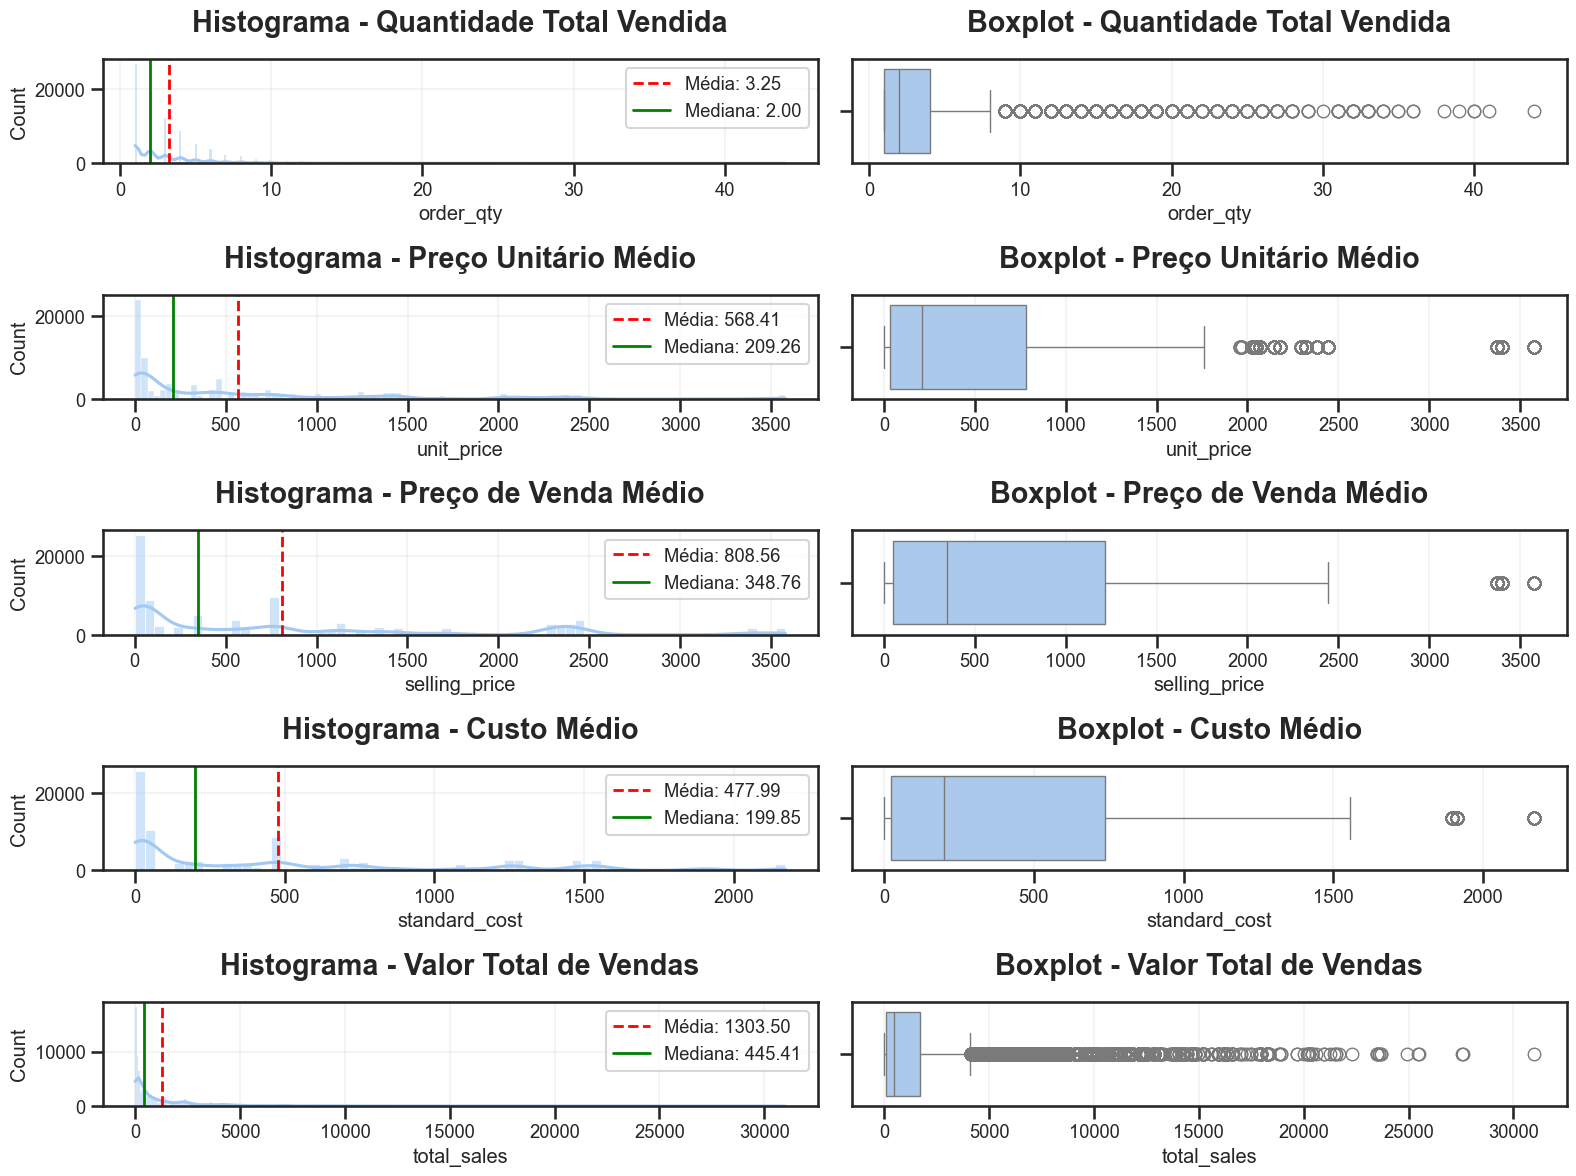

In [20]:
fig, axes = plt.subplots(5, 2, figsize=(16, 12))

# Lista com variáveis e títulos
variaveis = [
    ("order_qty", "Quantidade Total Vendida"),
    ("unit_price", "Preço Unitário Médio"),
    ("selling_price", "Preço de Venda Médio"),
    ("standard_cost", "Custo Médio"),
    ("total_sales", "Valor Total de Vendas")
]

# Loop para gerar os gráficos
for i, (col, titulo) in enumerate(variaveis):
    media = df_processed[col].mean()
    mediana = df_processed[col].median()

    # Histograma
    sns.histplot(df_processed[col], kde=True, ax=axes[i, 0])
    axes[i, 0].axvline(media, color='red', linestyle='--', linewidth=2, label=f"Média: {media:.2f}")
    axes[i, 0].axvline(mediana, color='green', linestyle='-', linewidth=2, label=f"Mediana: {mediana:.2f}")
    axes[i, 0].set_title(f"Histograma - {titulo}")
    axes[i, 0].legend()

    # Boxplot
    sns.boxplot(x=df_processed[col], ax=axes[i, 1])
    axes[i, 1].set_title(f"Boxplot - {titulo}")

plt.tight_layout()
plt.show()


Para facilitar a análise das distribuições, realizarei o agrupamento por produto, com o objetivo de identificar possíveis casos em que a média e a contagem apresente valores inconsistentes.

In [21]:
# Agrupando por produtos
df_produtos =  df_processed.groupby(['name_product']).agg(
    order_qty=('order_qty', 'sum'),
    unit_price=('unit_price', 'mean'),
    total_sales=('total_sales', 'sum'),
    selling_price=('selling_price', 'mean'),
    standard_cost=('standard_cost', 'mean')
).reset_index()

df_produtos.head()

,name_product,order_qty,unit_price,total_sales,selling_price,standard_cost
0,AWC Logo Cap,8311,6.17,51512.28,8.99,6.92
1,All-Purpose Bike Stand,249,159.00,39591.00,159.00,59.47
2,Bike Wash - Dissolver,3319,6.20,18518.57,7.95,2.97
3,Cable Lock,1087,14.99,16264.00,25.00,10.31
4,Chain,774,12.14,9385.69,20.24,8.99


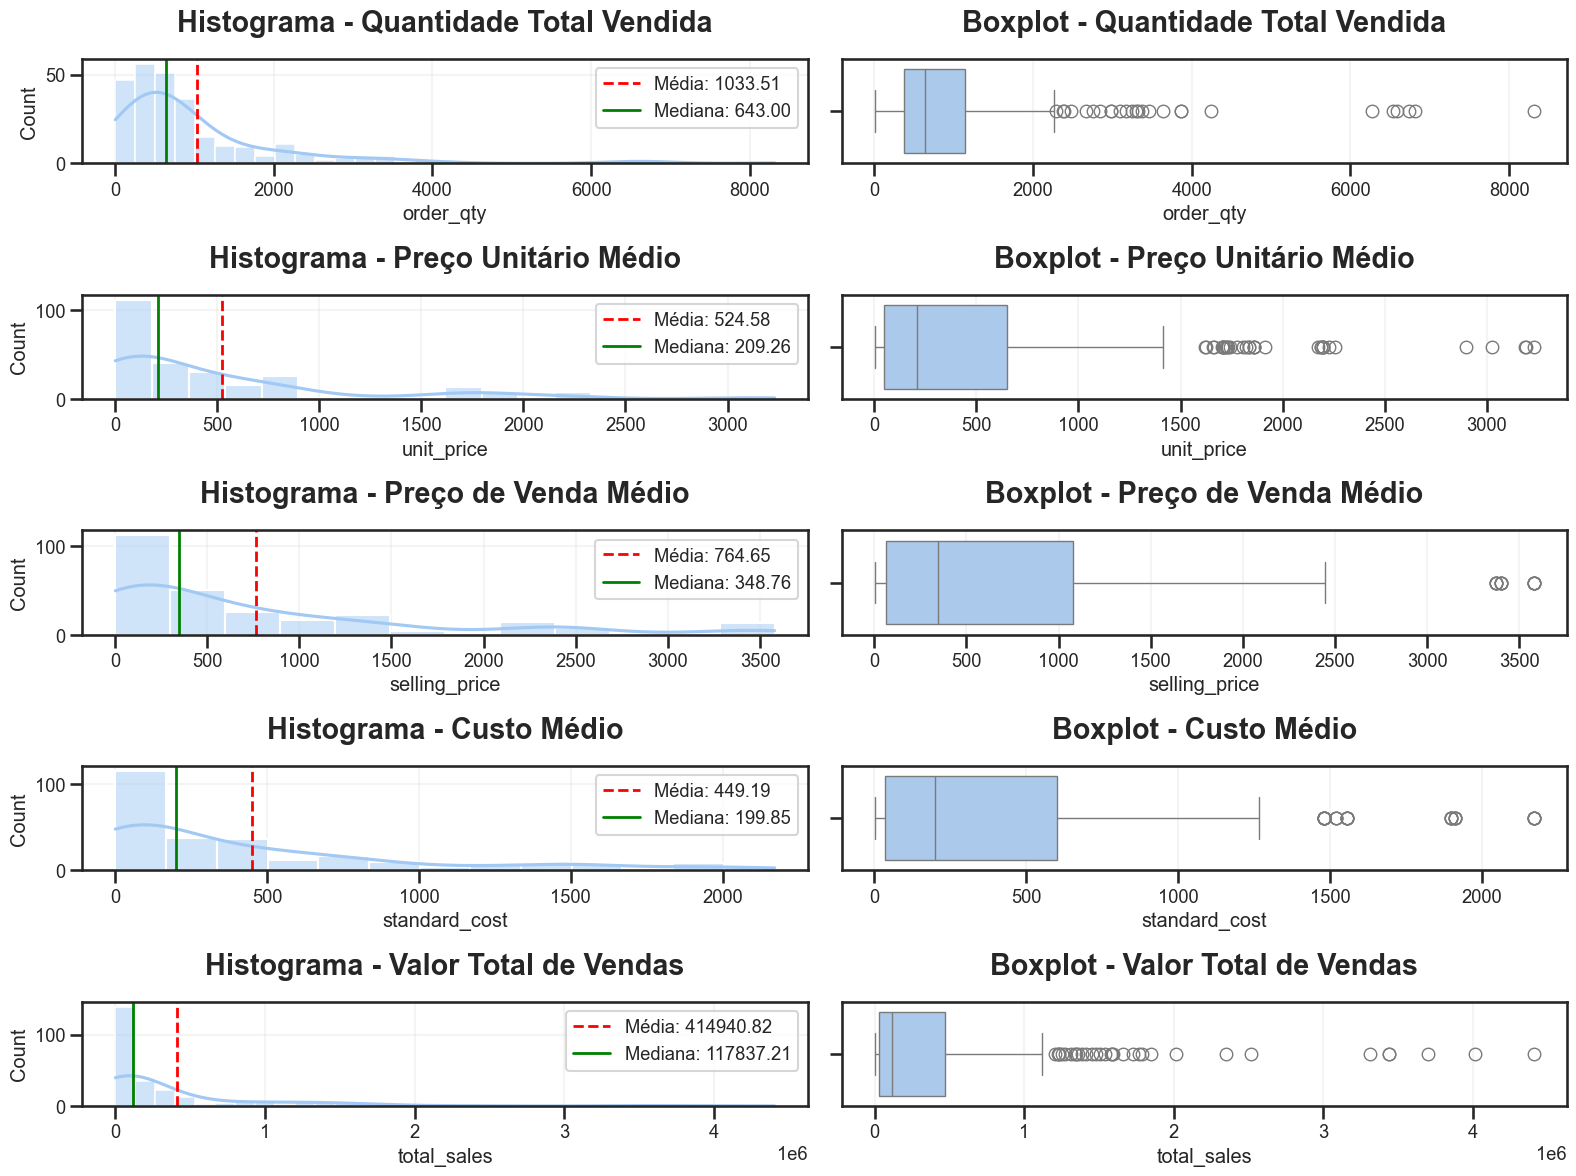

In [22]:
fig, axes = plt.subplots(5, 2, figsize=(16, 12))

# Lista com variáveis e títulos
variaveis = [
    ("order_qty", "Quantidade Total Vendida"),
    ("unit_price", "Preço Unitário Médio"),
    ("selling_price", "Preço de Venda Médio"),
    ("standard_cost", "Custo Médio"),
    ("total_sales", "Valor Total de Vendas")
]

# Loop para gerar os gráficos
for i, (col, titulo) in enumerate(variaveis):
    media = df_produtos[col].mean()
    mediana = df_produtos[col].median()

    # Histograma
    sns.histplot(df_produtos[col], kde=True, ax=axes[i, 0])
    axes[i, 0].axvline(media, color='red', linestyle='--', linewidth=2, label=f"Média: {media:.2f}")
    axes[i, 0].axvline(mediana, color='green', linestyle='-', linewidth=2, label=f"Mediana: {mediana:.2f}")
    axes[i, 0].set_title(f"Histograma - {titulo}")
    axes[i, 0].legend()

    # Boxplot
    sns.boxplot(x=df_produtos[col], ax=axes[i, 1])
    axes[i, 1].set_title(f"Boxplot - {titulo}")

plt.tight_layout()
plt.show()

In [23]:
@interact(cols = ['order_qty', 'unit_price', 'selling_price', 'standard_cost', 'total_sales'])

def view_outliers(cols):
    df = df_produtos.sort_values(cols, ascending=False).head()
    return df

interactive(children=(Dropdown(description='cols', options=('order_qty', 'unit_price', 'selling_price', 'stand…

As distribuições apresentadas indicam a presença de outliers e assimetria positiva.

A inspeção dos outliers mostra que estes se encontram dentro de padrões esperados, não havendo indícios de erros de imputação ou registros inconsistentes.

### Analíse dos Produtos de Forma Segmentada

In [24]:
# Adicionando Metadados
df_produtos = pd.merge(df_produtos, product_metadata, on='name_product', how='left')
df_produtos.head()

,name_product,order_qty,unit_price,total_sales,selling_price,standard_cost,fk_product,product_category_name,sub_category_name,product_line_name,product_class_name,is_manufactured,country_region_code,territory_group
0,AWC Logo Cap,8311,6.17,51512.28,8.99,6.92,712,Clothing,Caps,Standard,Unknown,False,US,North America
1,All-Purpose Bike Stand,249,159.00,39591.00,159.00,59.47,879,Accessories,Bike Stands,Mountain,Unknown,False,AU,Pacific
2,Bike Wash - Dissolver,3319,6.20,18518.57,7.95,2.97,877,Accessories,Cleaners,Standard,Unknown,False,GB,Europe
3,Cable Lock,1087,14.99,16264.00,25.00,10.31,843,Accessories,Locks,Standard,Unknown,False,US,North America
4,Chain,774,12.14,9385.69,20.24,8.99,952,Components,Chains,Unknown,Unknown,False,US,North America


A função interativa permitiu simplificar as análises de forma agrupada. Entretanto, devido a limitações do Jupyter Notebook, o recurso não permanece disponível após a exportação, sendo necessário executar novamente o código para visualizar o objeto interativo.

In [25]:
# Dataframe agrupado interativo
@interact(cols = ['product_category_name','sub_category_name',
                  'product_line_name','product_class_name',
                  'is_manufactured','country_region_code',
                  'territory_group'])

def view_groupby(cols):
    df = df_produtos.groupby(cols).agg(
        order_qty=('order_qty', 'sum'),
        unit_price_mean=('unit_price', 'mean'),
        total_sales=('total_sales', 'sum'),
        selling_price_mean=('selling_price', 'mean'),
        standard_cost_mean=('standard_cost', 'mean')
    ).sort_values('order_qty', ascending=False).reset_index()
    
    return df

interactive(children=(Dropdown(description='cols', options=('product_category_name', 'sub_category_name', 'pro…

**1 - `País/Region`**

Estados Unidos (US) lideram com folga em quantidade vendida (151.561 unidades) e mantêm preços unitários e de venda médios elevados (US$ 519,77 e US$ 772,04, respectivamente).

Canadá (CA) também apresenta volume relevante (56.433 unidades), com preços semelhantes aos dos EUA.

Austrália (AU) apresenta preços médios significativamente mais altos (unitário: US$ 795,55; venda: US$ 1.082,39), o que pode indicar foco em produtos premium ou nichados.

Países europeus como Alemanha (DE) e Reino Unido (GB) têm preços intermediários, enquanto a França (FR) apresenta custos médios relativamente próximos dos preços de venda, sugerindo margens menores.

**`Continente`**

América do Norte lidera em volume (207.994 unidades) e mantém preços médios altos, reforçando a importância deste mercado.

Pacífico possui preços unitários mais altos (US$ 795,55), mas menor volume, sugerindo foco em nichos de maior valor.

Europa apresenta preços intermediários, mas volume menor, o que pode indicar oportunidades de crescimento.


**2 - `Produto: Manufaturado x Não-Manufaturado`**

Produtos manufaturados têm ticket médio muito mais alto (unitário: US$ 721,51; venda: US$ 1.052,22) e custos elevados (US$ 620,61), mas representam valor agregado significativo.


Produtos não manufaturados possuem grande volume de vendas (143.487 unidades) e preços unitários muito mais baixos (US$ 32,23), sugerindo alto giro e foco em escala.

**3 - `Categoria de Produto`**

Bikes são o segmento mais lucrativo em valor unitário (unitário: US$ 1.135,03; venda: US$ 1.586,74) e com maior volume (90.268 unidades).

Clothing e Accessories têm preços baixos, mas movimentam grande quantidade, caracterizando-se como produtos de alta rotatividade.

Components apresentam ticket médio intermediário, possivelmente vinculados a vendas de reposição ou customização.


**4 - `Linha de Produto`**

Road e Mountain concentram os maiores preços unitários (US$ 734,76 e US$ 540,06, respectivamente), provavelmente por serem bicicletas e equipamentos especializados.

Standard lidera em volume (96.374 unidades) com baixo preço unitário, o que reforça seu apelo de massa.

Touring possui ticket elevado (US$ 623,74), indicando posicionamento premium.

Os produtos com categoria desconhecidos representam uma menor quantidade vendida, mas pode representar um ponto de melhoria para padronização de cadastros.

**5 - `Classe de Produto`**

Classe High domina no valor unitário (US$ 1.198,53) e de venda (US$ 1.708,32), sendo produtos de alto valor agregado.

Classe Low e Medium ocupam o segmento intermediário, enquanto produtos de  classe desconhecida concentra volume (132.477 unidades) com preços baixos, novamente apontando possível inconsistência de cadastro ou segmentação.


### Análise de Série Temporal

Para enriquecer a análise criarei features basedas na data da venda

In [26]:
# Criação de features baseadas na data
df_processed['month'] = df_processed.order_date_dt.dt.month.astype(str).astype('category')
df_processed['year'] = df_processed.order_date_dt.dt.year.astype(str).astype('category')
df_processed['day_of_week'] = df_processed.order_date_dt.dt.dayofweek.astype(str).astype('category')
df_processed['day_of_year'] = df_processed.order_date_dt.dt.dayofyear.astype('category')
df_processed['week_of_year'] = df_processed.order_date_dt.dt.isocalendar().week.astype(str).astype('category')
df_processed['month_year'] = df_processed['order_date_dt'].dt.strftime('%Y-%m').astype('category')

df_processed.head()

,order_date_dt,fk_product,order_qty,unit_price,selling_price,standard_cost,name_store,name_product,product_category_name,sub_category_name,...,is_manufactured,country_region_code,territory_group,total_sales,month,year,day_of_week,day_of_year,week_of_year,month_year
0,2012-07-31,759,2,469.79,782.99,486.71,Fitness Hotel,"Road-650 Red, 58",Bikes,Road Bikes,...,True,US,North America,939.59,7,2012,1,213,31,2012-07
1,2012-07-31,769,1,469.79,782.99,486.71,Fitness Hotel,"Road-650 Black, 48",Bikes,Road Bikes,...,True,US,North America,469.79,7,2012,1,213,31,2012-07
2,2012-07-31,827,3,165.23,275.38,122.27,Fitness Hotel,ML Road Rear Wheel,Components,Wheels,...,True,US,North America,495.69,7,2012,1,213,31,2012-07
3,2012-07-31,839,1,780.82,1431.50,868.63,Fitness Hotel,"HL Road Frame - Black, 48",Components,Road Frames,...,True,US,North America,780.82,7,2012,1,213,31,2012-07
4,2012-10-30,727,1,202.33,337.22,187.16,Fitness Hotel,"LL Road Frame - Red, 52",Components,Road Frames,...,True,CA,North America,202.33,10,2012,1,304,44,2012-10


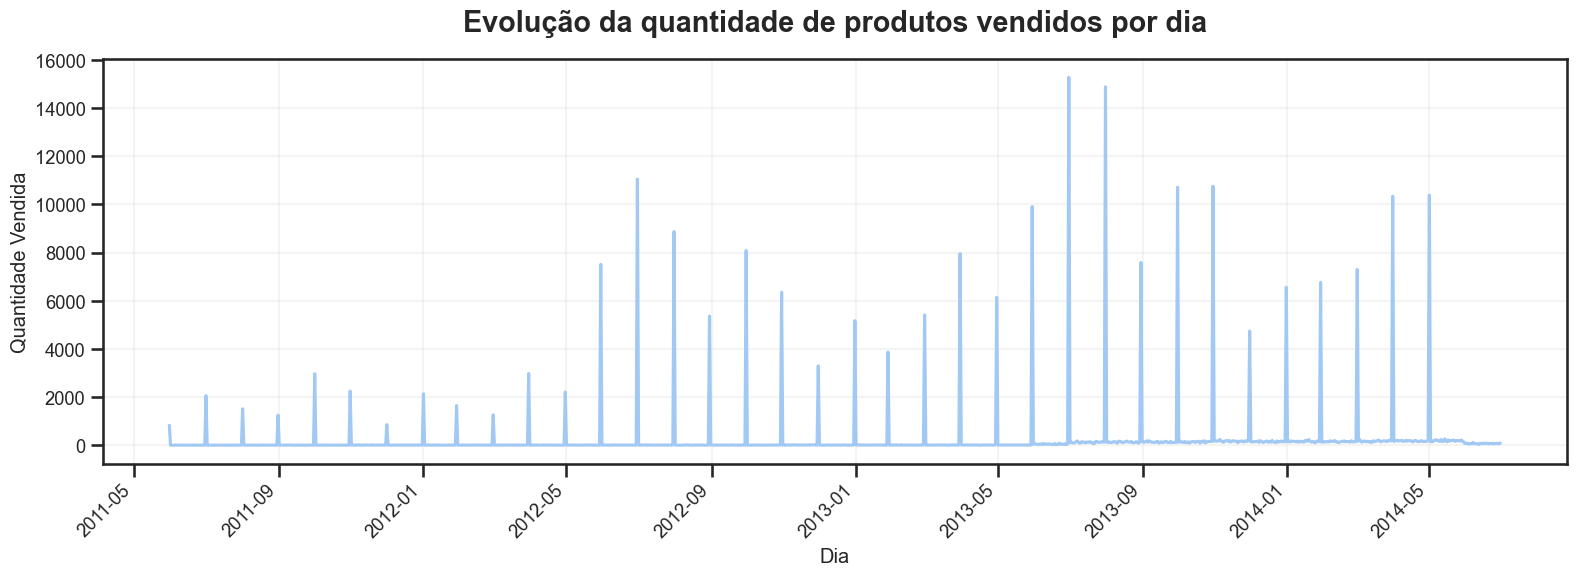

In [27]:
# Grafico de linha de qtd vendida
plt.figure(figsize=(16, 6))
sns.lineplot(data=df_processed.groupby('order_date_dt')[['order_qty']].sum().reset_index(), 
             x='order_date_dt', 
             y='order_qty')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Dia')
plt.ylabel('Quantidade Vendida')
plt.title('Evolução da quantidade de produtos vendidos por dia')
plt.tight_layout()

plt.show()

### Agrupando os dados para identificar sazonalidade

In [28]:
@interact(cols = ['month', 'year','day_of_week','day_of_year','week_of_year','month_year'])
def view_groupby(cols):
    df = df_processed.groupby(cols).agg(
        order_qty=('order_qty', 'sum'),
        faturamento=('total_sales', 'sum')
        ).sort_values('order_qty', ascending=False).reset_index()
    return df.style.background_gradient(subset=['order_qty','faturamento'], 
                                     cmap='YlGnBu').format({'order_qty': '{:,.0f}',
                                                            'faturamento': '{:,.2f}'})

interactive(children=(Dropdown(description='cols', options=('month', 'year', 'day_of_week', 'day_of_year', 'we…

In [29]:

@interact(cols = ['month', 'year','day_of_week','day_of_year','week_of_year','month_year'])
def view_groupby(cols):
    # Agrega quantidade e faturamento por grupo
    df_grouped = df_processed.groupby(cols).agg(
        order_qty=('order_qty', 'sum'),
        faturamento=('total_sales', 'sum')
    )

    # Produto mais vendido por grupo
    top_products = df_processed.groupby(cols).apply(
        lambda x: x.loc[x['order_qty'].idxmax(), 'name_product']
    ).rename('produto_mais_vendido')

    # Junta o produto mais vendido com a agregação
    df_grouped = df_grouped.join(top_products).reset_index()

    # Estilo com heatmap
    return df_grouped.style.background_gradient(
        subset=['order_qty','faturamento'], cmap='YlGnBu'
    ).format({'order_qty': '{:,.0f}', 'faturamento': '{:,.2f}'})

interactive(children=(Dropdown(description='cols', options=('month', 'year', 'day_of_week', 'day_of_year', 'we…

In [30]:
#Agrupando por mes ano
df_mes_ano = df_processed.groupby('month_year').agg(
        order_qty=('order_qty', 'sum'),
        faturamento=('total_sales', 'sum')
    ).sort_values('month_year', ascending=True)\
        .reset_index()

df_mes_ano.style.background_gradient(subset=['order_qty','faturamento'], 
                                     cmap='YlGnBu').format({'order_qty': '{:,.0f}',
                                                            'faturamento': '{:,.2f}'})

,month_year,order_qty,faturamento
0,2011-05,825,"503,805.92"
1,2011-06,141,"458,910.82"
2,2011-07,"2,209","2,046,265.09"
3,2011-08,"2,904","2,496,365.01"
4,2011-09,157,"502,073.85"
5,2011-10,"5,382","4,590,874.87"
6,2011-11,230,"737,839.82"
7,2011-12,"1,040","1,309,976.78"
8,2012-01,"3,967","3,970,636.43"
9,2012-02,"1,442","1,475,538.36"


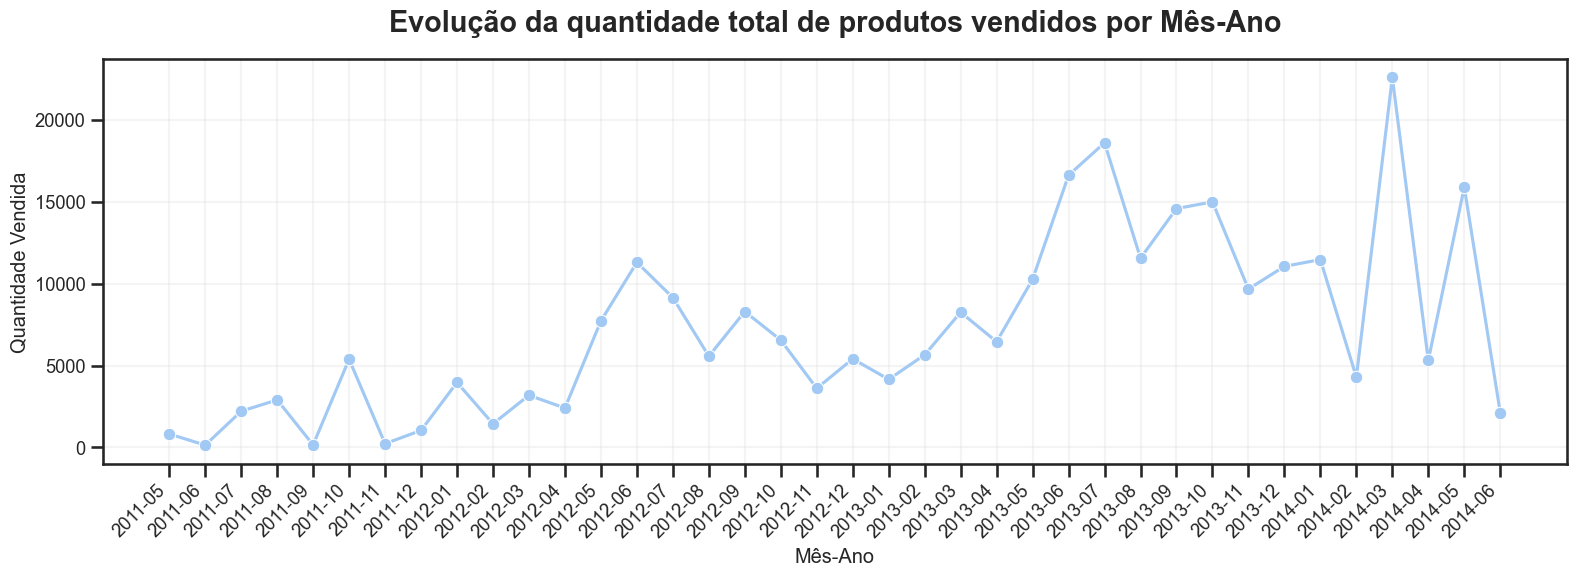

In [31]:
# Grafico de linha de qtd vendida
plt.figure(figsize=(16, 6))
sns.lineplot(data=df_mes_ano, x='month_year', y='order_qty', marker='o')
plt.xticks(rotation=45, ha='right') 
plt.xlabel('Mês-Ano')
plt.ylabel('Quantidade Vendida')
plt.title('Evolução da quantidade total de produtos vendidos por Mês-Ano')
plt.tight_layout()

plt.show()

Gráfico interativo para visualizar a série temporal por item

In [32]:
@interact(product_name = df_processed['name_product'].unique())

def view_lineplot_per_product(product_name):
    df_product_filtrado = df_processed[df_processed['name_product'] == product_name]
    df_mes_ano = df_product_filtrado.groupby(['month_year','name_product']).agg(
        order_qty=('order_qty', 'sum'),
        unit_price=('total_sales', 'sum')
        ).sort_values('month_year', ascending=True)\
            .reset_index()

    # Grafico de linha de qtd vendida
    fig = plt.figure(figsize=(16, 6))
    sns.lineplot(data=df_mes_ano, x='month_year', y='order_qty', marker='o')
    plt.xticks(rotation=45, ha='right')  # rotaciona os labels
    plt.xlabel('Mês-Ano')
    plt.ylabel('Quantidade Vendida')
    plt.title(f'Evolução da venda do produto: {product_name}')
    plt.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='product_name', options=('Road-650 Red, 58', 'Road-650 Black, 48', …

In [33]:
# Somando as vendas de todas as lojas
df_monthly_product = (
    df_processed
    .groupby(['month_year', 'name_product'], observed=True, as_index=False)
    .agg(total_qty=('order_qty', 'sum'))
)

# Produto com maior quantidade vendida por mês e ano
top_products = (
    df_monthly_product
    .loc[df_monthly_product.groupby('month_year', observed=True)['total_qty'].idxmax()]
    .sort_values(['month_year'])
    .reset_index(drop=True)
)

top_products


,month_year,name_product,total_qty
0,2011-05,"Long-Sleeve Logo Jersey, L",49
1,2011-06,"Road-150 Red, 48",28
2,2011-07,"Mountain Bike Socks, M",134
3,2011-08,"Mountain Bike Socks, M",167
4,2011-09,"Road-150 Red, 62",27
5,2011-10,AWC Logo Cap,240
6,2011-11,"Road-150 Red, 48",40
7,2011-12,"Road-650 Black, 52",52
8,2012-01,"Mountain Bike Socks, M",181
9,2012-02,"Mountain Bike Socks, M",78


In [34]:
# Contagem de quantos meses cada produto foi o mais vendido
top_products.groupby('name_product', observed=True)\
            .size()\
            .reset_index(name='num_months')\
            .style.highlight_max(subset='num_months', color='green')

,name_product,num_months
0,AWC Logo Cap,2
1,"Classic Vest, S",2
2,"Full-Finger Gloves, L",12
3,"Long-Sleeve Logo Jersey, L",2
4,"Mountain Bike Socks, M",4
5,Mountain Tire Tube,1
6,"Road-150 Red, 48",2
7,"Road-150 Red, 62",1
8,"Road-650 Black, 52",1
9,Water Bottle - 30 oz.,11


In [35]:
# Extrair apenas o número do mês
top_products['month'] = pd.to_datetime(top_products['month_year']).dt.month

# Contar quantas vezes cada produto foi campeão em cada mês
reincidencias = (
    top_products
    .groupby(['name_product', 'month'], observed=True)
    .size()
    .reset_index(name='num_times')
    .sort_values(['name_product', 'num_times'], ascending=[True, False])
)

# Filtrar apenas os casos em que o produto repetiu no mesmo mês
reincidencias[reincidencias['num_times'] > 1]

,name_product,month,num_times


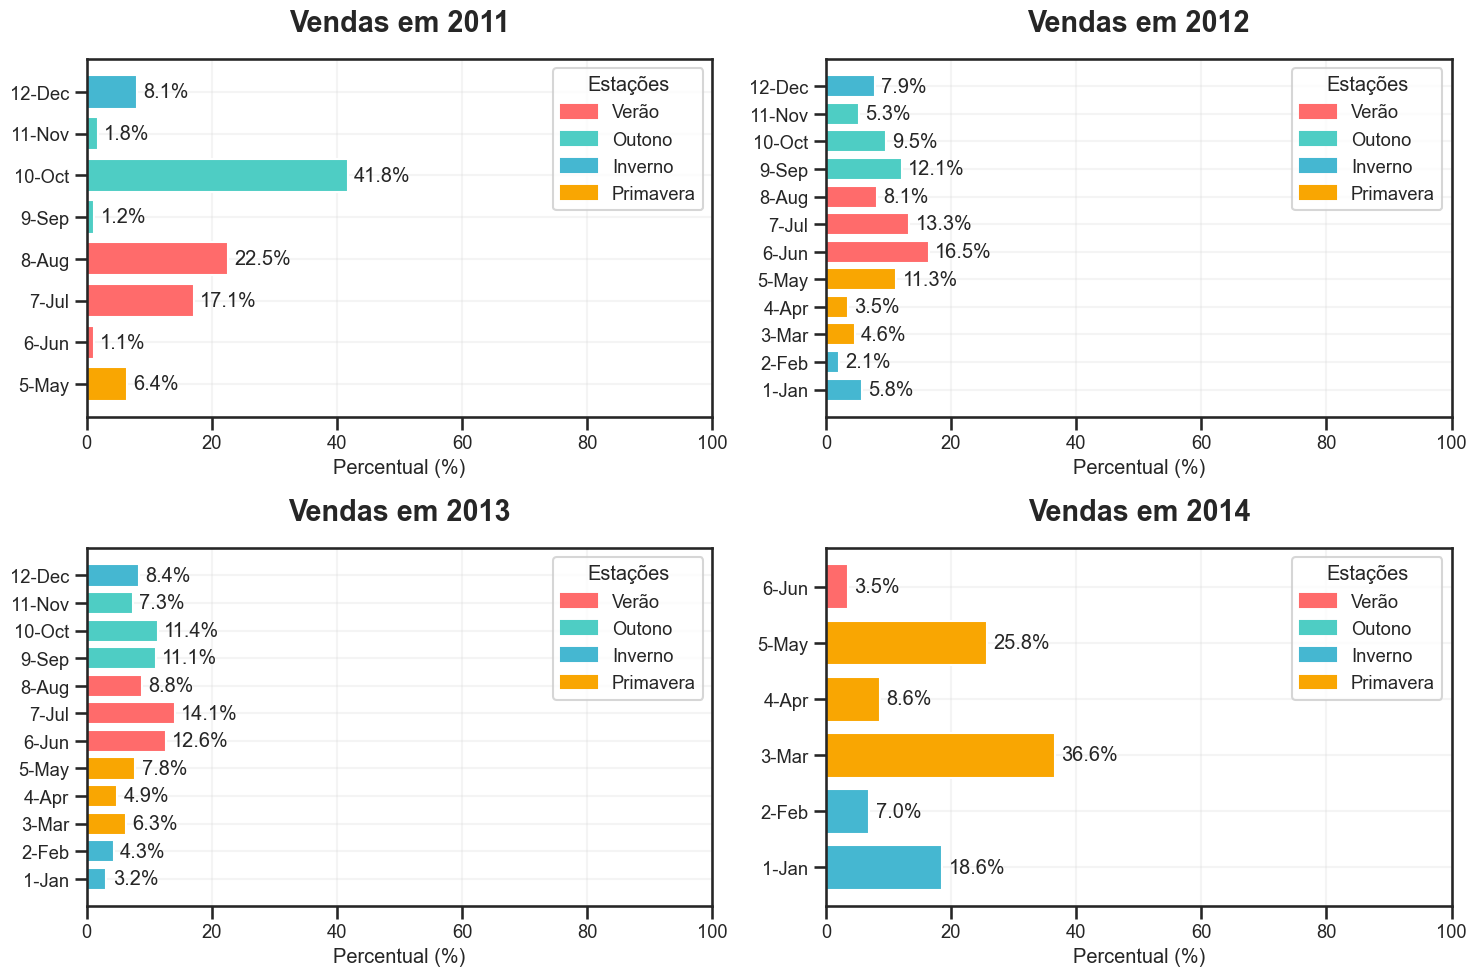

In [92]:
df_mes_ano['month_year'] = pd.to_datetime(df_mes_ano['month_year'])
df_mes_ano['year'] = df_mes_ano['month_year'].dt.year
df_mes_ano['month'] = df_mes_ano['month_year'].dt.month

# Definir as estações
seasons = {
    12: 'Inverno', 1: 'Inverno', 2: 'Inverno',
    3: 'Primavera', 4: 'Primavera', 5: 'Primavera',
    6: 'Verão', 7: 'Verão', 8: 'Verão',
    9: 'Outono', 10: 'Outono', 11: 'Outono'
}
df_mes_ano['season'] = df_mes_ano['month'].map(seasons)

# Cores para as estações
season_colors = {
    'Verão': '#FF6B6B',
    'Outono': '#4ECDC4',
    'Inverno': '#45B7D1',
    'Primavera': '#F9A602'
}

# Criar subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
years = sorted(df_mes_ano['year'].unique())

legend_patches = [
    mpatches.Patch(color=color, label=season)
    for season, color in season_colors.items()
]


for i, year in enumerate(years):
    df_year = df_mes_ano[df_mes_ano['year'] == year].copy()
    total_year = df_year['order_qty'].sum()
    df_year['percentage'] = (df_year['order_qty'] / total_year) * 100
    
    # Ordenar por mês
    df_year = df_year.sort_values('month')
    
    # Criar barras
    bars = axes[i].barh(
        df_year['month'].astype(str) + '-' + df_year['month_year'].dt.strftime('%b'),
        df_year['percentage'],
        color=[season_colors[s] for s in df_year['season']]
    )
    
    axes[i].set_title(f'Vendas em {year}')
    axes[i].set_xlabel('Percentual (%)')
    axes[i].set_xlim(0, 100)
    
    # Adicionar porcentagens nas barras
    for bar in bars:
        width = bar.get_width()
        axes[i].text(width + 1, bar.get_y() + bar.get_height()/2,
                    f'{width:.1f}%', ha='left', va='center')
    for ax in axes:
        ax.legend(handles=legend_patches, title="Estações", loc="best")

# Ajustar layout
plt.tight_layout()
plt.show()

### Decomposição da Série Temporal

A decomposição de série temporal é uma técnica que separa uma série de dados em componentes distintos: tendência, sazonalidade e resíduos. Permitindo entender melhor o comportamento da série.

Devido a granularidade distintas dos produtos utilizei o `STL` (Seasonal and Trend decomposition using Loess) que é um método flexível de decomposição que usa suavização local `LOESS` para extrair a tendência e a sazonalidade de forma robusta. Diferente da decomposição clássica, o STL lida bem com sazonalidade variável no tempo e com outliers, permitindo ajustar os componentes de maneira mais precisa com os dados da Adventure Works.

In [36]:
# Agrupando por quantidade vendida
df_time_series = df_processed.groupby('order_date_dt')[['order_qty']].sum()
df_time_series.head()

,order_qty
order_date_dt,
2011-05-31,825
2011-06-01,4
2011-06-02,5
2011-06-03,2
2011-06-04,5


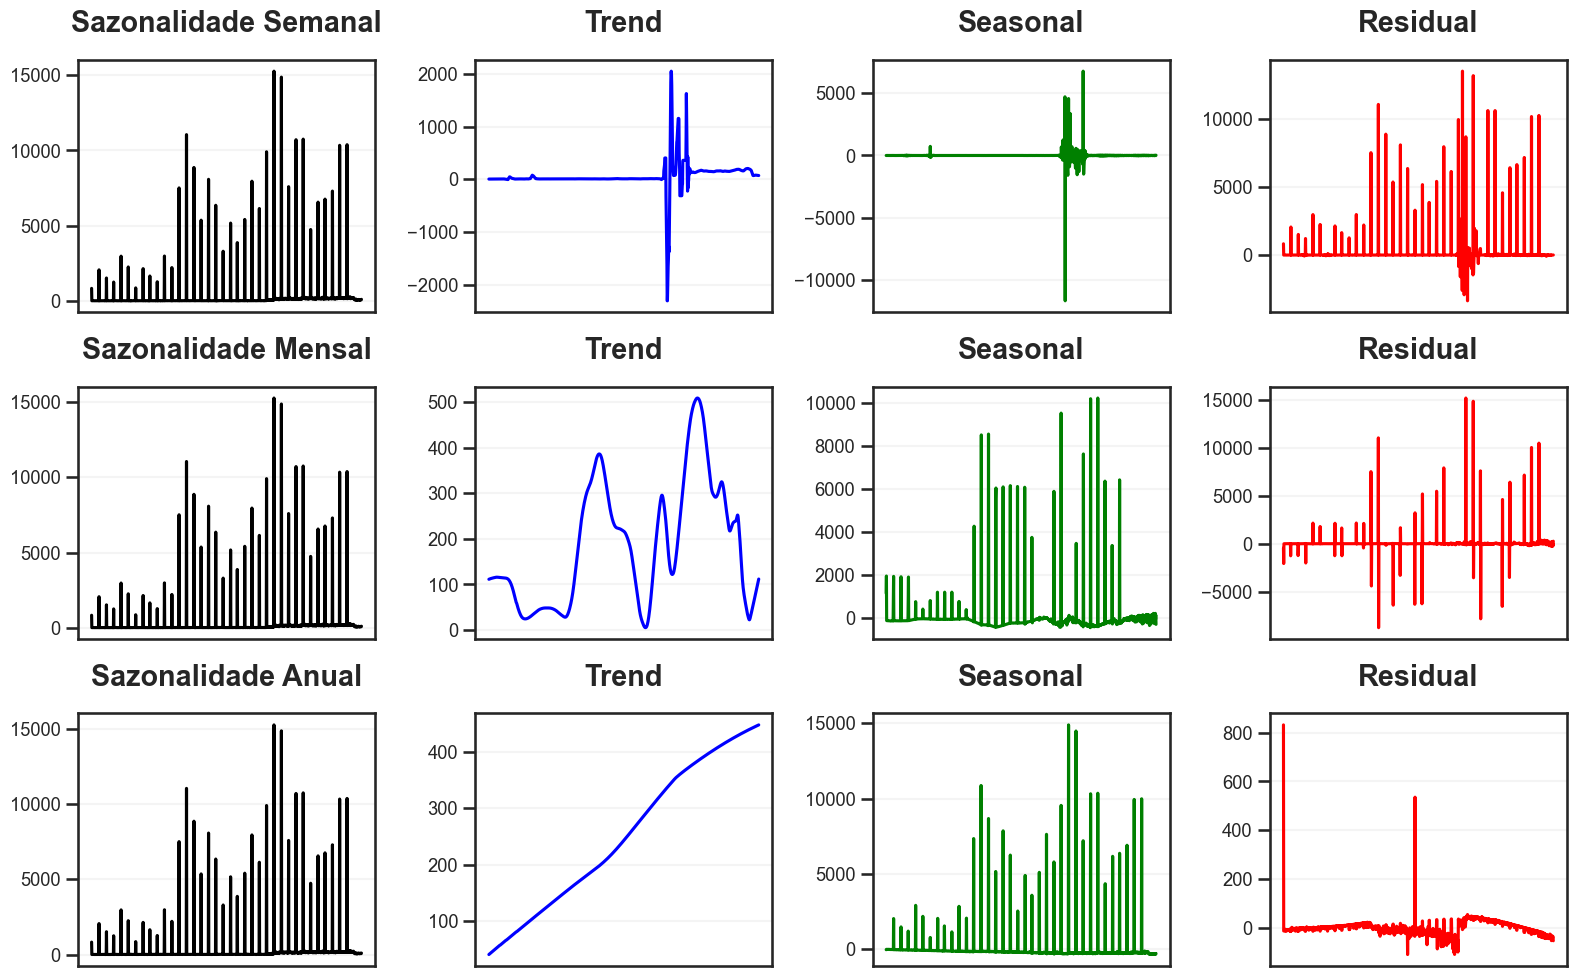

In [37]:
# Periodos
periodos = [
    (7, "Sazonalidade Semanal"),
    (30, "Sazonalidade Mensal"),
    (365, "Sazonalidade Anual")
]

# Subplots da decomposição da Serie Temporal
fig, axes = plt.subplots(len(periodos), 4, figsize=(16, 10))

for i, (period, titulo) in enumerate(periodos):
    stl = STL(df_time_series['order_qty'], period=period, robust=True)
    result = stl.fit()

    # Série original
    axes[i, 0].plot(df_time_series.index, df_time_series['order_qty'], color='black')
    axes[i, 0].set_title(f"{titulo}")

    # Tendência
    axes[i, 1].plot(df_time_series.index, result.trend, color='blue')
    axes[i, 1].set_title("Trend")

    # Sazonalidade
    axes[i, 2].plot(df_time_series.index, result.seasonal, color='green')
    axes[i, 2].set_title("Seasonal")

    # Resíduo
    axes[i, 3].plot(df_time_series.index, result.resid, color='red')
    axes[i, 3].set_title("Residual")

# Removendo xticks
for ax in axes.flatten():
    ax.set_xticks([])
plt.tight_layout()
plt.show()

Graficamente é possivel analisar que as vendas totais possuem uma tendencia de alta e um padrão de sazonalidade, onde alguns meses possuem uma média de vendas maior que os demais de uma forma repetitiva.

### Estacionariedade

Estacionariedade é a propriedade de uma série temporal em que suas características estatísticas, como média e variância, permanecem constantes ao longo do tempo.

Alguns modelos possuem a premissa que a série deve ser estacionária, caso a série não for estacionária, as previsões podem ser imprecisas, pois padrões de tendência ou sazonalidade podem distorcer os resultados do modelo.

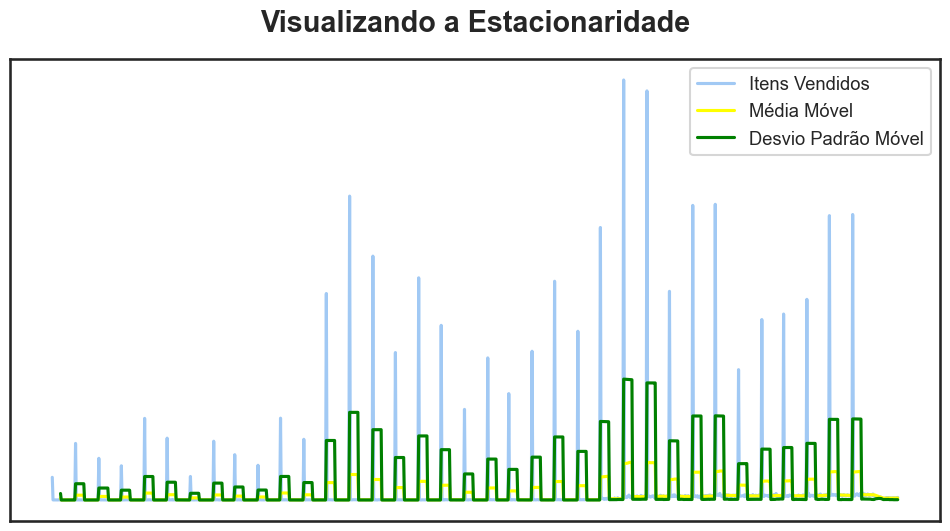

In [38]:
# Aplica a função de visualização de estacionariedade
visualiza_estacionaridade(df_time_series)

Devido à série apresentar muitos vales e picos distantes da média, a análise gráfica sozinha torna-se insuficiente para avaliar a estacionariedade dos dados. Por esse motivo, é necessário complementar a análise visual com o **teste estatístico: `Dickey-Fuller Aumentado`**.


### Teste Dickey-Fuller Aumentado
* Um valor-p menor que 0,05 significa que podemos rejeitar a hipótese nula de que os 
dados da série temporal não são estacionários. Portanto, a série temporal é estacionária.

* Um valor-p maior que 0,05 significa que não rejeitamos a hipótese nula. Portanto, a série temporal não é estacionária.

In [39]:
# Aplica o teste adfuller
resultado_adft = adfuller(df_time_series)

# Resultado
if resultado_adft[1] < 0.05:
    print('O valor-p é menor que 0.05. Podemos rejeitar a H0. A série é estacionária.')
else:
    print('O valor-p é maior que 0.05. Não podemos rejeitar a H0. A série não é estacionária.')

O valor-p é menor que 0.05. Podemos rejeitar a H0. A série é estacionária.


Função interativa abaixo para visualizar e facilitar a decomposição da série temporal, análise grafica de estacionariedade e teste estatístico dickey-fuller aumentado por produto.

In [40]:
# Função interativa de decomposição de serie temporal
@interact(produtos = set(df_processed['name_product']))

def view_seasonal_decompose(produtos):
    df_time_series = df_processed[df_processed['name_product'] == produtos]

    df_time_series = df_time_series.groupby('order_date_dt')[['order_qty']].sum()
    
    # Periodos
    periodos = [
        (7, "Sazonalidade Semanal"),
        (30, "Sazonalidade Mensal"),
        (365, "Sazonalidade Anual")
    ]

    # Subplots da decomposição da Serie Temporal
    fig, axes = plt.subplots(len(periodos), 4, figsize=(12, 8))

    for i, (period, titulo) in enumerate(periodos):
        stl = STL(df_time_series['order_qty'], period=period, robust=True)
        result = stl.fit()

        # Série original
        axes[i, 0].plot(df_time_series.index, df_time_series['order_qty'], color='black')
        axes[i, 0].set_title(f"{titulo}")

        # Tendência
        axes[i, 1].plot(df_time_series.index, result.trend, color='blue')
        axes[i, 1].set_title("Trend")

        # Sazonalidade
        axes[i, 2].plot(df_time_series.index, result.seasonal, color='green')
        axes[i, 2].set_title("Seasonal")

        # Resíduo
        axes[i, 3].plot(df_time_series.index, result.resid, color='red')
        axes[i, 3].set_title("Residual")

    # Removendo xticks
    for ax in axes.flatten():
        ax.set_xticks([])
    plt.tight_layout()
    plt.show()

    # Aplica o teste adfuller
    resultado_adft = adfuller(df_time_series)

    # Resultado
    if resultado_adft[1] < 0.05:
        print('\nO valor-p é menor que 0.05. Podemos rejeitar a H0. A série é estacionária.')
    else:
        print('\nO valor-p é maior que 0.05. Não podemos rejeitar a H0. A série não é estacionária.')
    visualiza_estacionaridade(df_time_series)


interactive(children=(Dropdown(description='produtos', options=("Women's Mountain Shorts, L", 'Mountain-300 Bl…

# Médias Móveis

Antes de executar as previsões para todos os produtos e lojas, é necessário padronizar as séries temporais.
Para isso, realizei o preenchimento dos valores ausentes correspondentes a meses sem vendas, atribuindo o valor 0.

Esse tratamento garante que:

* Todas as combinações de produto e loja possuam a mesma sequência de datas.
* Não haja discrepâncias de dimensão entre as séries temporais.
* O modelo de previsão possa ser aplicado de forma consistente em todos os casos.

In [41]:
#Obtendo listas de lojas e produtos únicos
listas_lojas = list(set(df_processed['name_store']))
listas_produtos = list(set(df_processed['name_product']))

# Quantidade de lojas e produtos
print(f'Número de Lojas: {len(listas_lojas)}\nNúmero de Produtos: {len(listas_produtos)}')

Número de Lojas: 634
Número de Produtos: 266


In [42]:
# Agrupando a somatoria de vendas por loja e produto de forma mensal
df_monthly = df_processed.groupby(
    ['name_store', 'name_product', pd.Grouper(key='order_date_dt', freq='M')]
)['order_qty'].sum().reset_index()

df_monthly.head()

,name_store,name_product,order_date_dt,order_qty
0,A Bike Store,"LL Road Frame - Black, 52",2011-07-31,1
1,A Bike Store,"LL Road Frame - Black, 52",2011-10-31,1
2,A Bike Store,"LL Road Frame - Black, 58",2012-03-31,2
3,A Bike Store,"LL Road Frame - Red, 44",2011-10-31,3
4,A Bike Store,"LL Road Frame - Red, 44",2012-03-31,1


In [43]:
# Obtendo data mínima e máxima
min_date = df_monthly['order_date_dt'].min()
max_date = df_monthly['order_date_dt'].max()
future_max_date = max_date + pd.DateOffset(months=3) 


# Criando um range de datas
future_date_range = pd.date_range(start=min_date, end=future_max_date, freq='M')
print(f'Data mínima: {min_date}\nData máxima: {max_date}\nData final de previsão: {future_max_date}\nQuantidade de meses: {len(future_date_range)}')

Data mínima: 2011-05-31 00:00:00
Data máxima: 2014-06-30 00:00:00
Data final de previsão: 2014-09-30 00:00:00
Quantidade de meses: 41


In [44]:
# Cria um índice múltiplo com todas as combinações de lojas, produtos e datas
full_index = pd.MultiIndex.from_product(
    [listas_lojas, listas_produtos, future_date_range],
    names=['name_store', 'name_product', 'order_date_dt']
)

# Criando o novo DataFrame a partir do índice completo contendo todas os meses disponiveis para cada produto e loja
df_full = pd.DataFrame(index=full_index).reset_index()
print(f'O conjunto de dados possui {len(df_full)} linhas.')
df_full.head()

O conjunto de dados possui 6914404 linhas.


,name_store,name_product,order_date_dt
0,Fitness Hotel,"Women's Mountain Shorts, L",2011-05-31
1,Fitness Hotel,"Women's Mountain Shorts, L",2011-06-30
2,Fitness Hotel,"Women's Mountain Shorts, L",2011-07-31
3,Fitness Hotel,"Women's Mountain Shorts, L",2011-08-31
4,Fitness Hotel,"Women's Mountain Shorts, L",2011-09-30


In [45]:
# Adiciono a quantidade de vendas por loja e produto e preencho os valores vazios com 0
df_merged = pd.merge(
    df_full,
    df_monthly,
    on=['name_store', 'name_product', 'order_date_dt'],
    how='left'
).fillna(0)
df_merged.head()

,name_store,name_product,order_date_dt,order_qty
0,Fitness Hotel,"Women's Mountain Shorts, L",2011-05-31,0.00
1,Fitness Hotel,"Women's Mountain Shorts, L",2011-06-30,0.00
2,Fitness Hotel,"Women's Mountain Shorts, L",2011-07-31,0.00
3,Fitness Hotel,"Women's Mountain Shorts, L",2011-08-31,0.00
4,Fitness Hotel,"Women's Mountain Shorts, L",2011-09-30,0.00


In [46]:
#Calcula a média móvel dos últimos 3 meses
window_size = 3
df_merged['order_qty_hist'] = df_merged['order_qty'].where(df_merged['order_date_dt'] <= max_date)

# Calcula a média móvel na coluna histórica
df_merged['rolling_mean'] = df_merged.groupby(['name_store', 'name_product'])['order_qty_hist'].transform(
    lambda x: x.rolling(window=window_size, min_periods=1).mean()
)

# A previsão é o último valor válido da média móvel, propagado para o futuro
# Uso o ffill (forward fill) para preencher os meses futuros com o último valor calculado
df_merged['previsao_demanda'] = df_merged.groupby(['name_store', 'name_product'])['rolling_mean'].transform('ffill')
df_merged['previsao_demanda'] = np.ceil(df_merged['previsao_demanda'])

# Removo as colunas auxiliares
df_merged.drop(columns=['order_qty_hist', 'rolling_mean'], inplace=True)
df_merged.head()

,name_store,name_product,order_date_dt,order_qty,previsao_demanda
0,Fitness Hotel,"Women's Mountain Shorts, L",2011-05-31,0.00,0.00
1,Fitness Hotel,"Women's Mountain Shorts, L",2011-06-30,0.00,0.00
2,Fitness Hotel,"Women's Mountain Shorts, L",2011-07-31,0.00,0.00
3,Fitness Hotel,"Women's Mountain Shorts, L",2011-08-31,0.00,0.00
4,Fitness Hotel,"Women's Mountain Shorts, L",2011-09-30,0.00,0.00


### Validação

### Abordagem atual Adventure Works: Sem divisão de conjunto de dados de treino e teste
A abordagem de validação descrita abaixo está **incorreta** e não segue as boas práticas de divisão do conjunto de dados em **treino** e **teste**.  

O objetivo, neste caso, não é realizar uma validação formal de modelo, mas sim **replicar o cenário atual da Adventure Works**, onde a previsão de demanda é feita com base nos **últimos 3 meses de vendas**.

As métricas geradas não são parâmetros de comparação para os outros modelos que estão sendo testados em dados previamente separados para teste.


In [47]:
# Obtendo dataframe de validação com os dados reais
df_eval = df_merged[df_merged['order_date_dt'] <= max_date].copy()

# Definindo as variáveis y_true e y_pred
y_true = df_eval['order_qty']
y_pred = df_eval['previsao_demanda']

# Calculando as métricas de validação
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

In [48]:
print("--- Métricas de Avaliação do Modelo ---")
print(f"MAE (Erro Absoluto Médio): {mae:.2f}")
print(f"MSE (Erro Quadrático Médio): {mse:.2f}")
print(f"RMSE (Raiz do Erro Quadrático Médio): {rmse:.2f}")
print(f"R² (Coeficiente de Determinação): {r2:.2f}")

--- Métricas de Avaliação do Modelo ---
MAE (Erro Absoluto Médio): 0.05
MSE (Erro Quadrático Médio): 0.20
RMSE (Raiz do Erro Quadrático Médio): 0.45
R² (Coeficiente de Determinação): 0.86


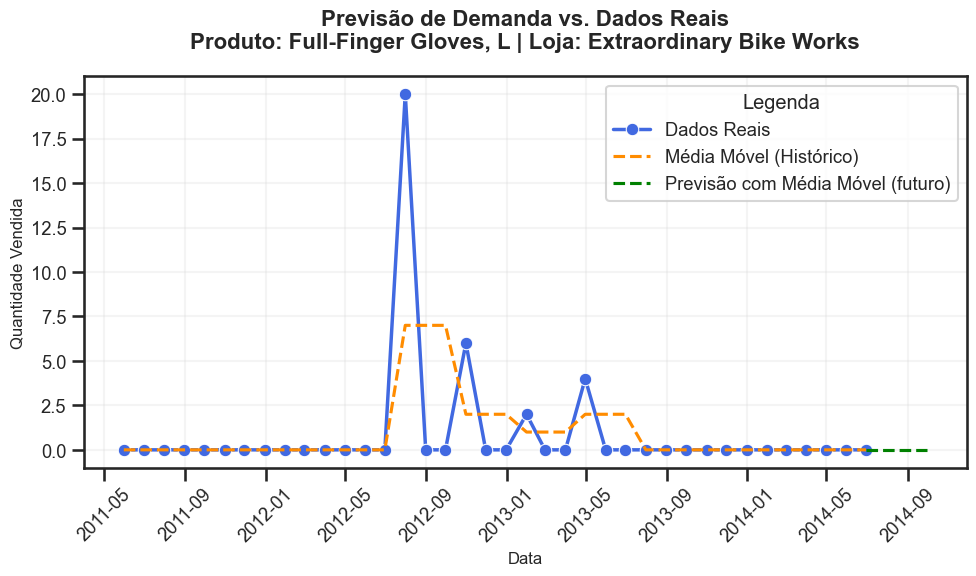

In [49]:
# Selecionando loja e produto
store_to_plot = 'Extraordinary Bike Works'
product_to_plot = 'Full-Finger Gloves, L'

view_prediction(store_to_plot, product_to_plot, df_merged)


Grafico interativo para verificar as predições por loja e produtos usando a média móvel

In [50]:
@interact(lojas = listas_lojas, produtos=listas_produtos)
def funcao_interativa(lojas, produtos):
    view_prediction(lojas, produtos, df_merged)

interactive(children=(Dropdown(description='lojas', options=('Fitness Hotel', 'Twelfth Bike Store', 'Requisite…

In [51]:
df_merged

,name_store,name_product,order_date_dt,order_qty,previsao_demanda
0,Fitness Hotel,"Women's Mountain Shorts, L",2011-05-31,0.00,0.00
1,Fitness Hotel,"Women's Mountain Shorts, L",2011-06-30,0.00,0.00
2,Fitness Hotel,"Women's Mountain Shorts, L",2011-07-31,0.00,0.00
3,Fitness Hotel,"Women's Mountain Shorts, L",2011-08-31,0.00,0.00
4,Fitness Hotel,"Women's Mountain Shorts, L",2011-09-30,0.00,0.00
...,...,...,...,...,...
6914399,General Associates,Rear Derailleur,2014-05-31,0.00,0.00
6914400,General Associates,Rear Derailleur,2014-06-30,0.00,0.00
6914401,General Associates,Rear Derailleur,2014-07-31,0.00,0.00
6914402,General Associates,Rear Derailleur,2014-08-31,0.00,0.00


In [52]:
lojas_americanas = set(df_processed[df_processed['territory_group'] == 'North America']['name_store'])

In [53]:
lojas_outras_regioes = set(df_processed[~df_processed['name_store'].isin(lojas_americanas)]['name_store'])

In [54]:
lojas_outras_regioes

{'Accessories Network',
 'Finer Mart',
 'Hometown Riding Supplies',
 'Jumbo Bikes',
 'Major Bicycle Store',
 'Nearest Bike Store',
 'Online Bike Catalog',
 'Quality Bike Sales',
 'Tubeless Tire Company',
 'Two-Seater Bikes',
 'Widget Bicycle Specialists'}

In [55]:
df_merged[
    (df_merged['order_date_dt'] > max_date) &
    (df_merged['name_store'].isin(lojas_americanas))
].groupby('order_date_dt')['previsao_demanda'].sum()


order_date_dt
2014-07-31   9836.00
2014-08-31   2130.00
2014-09-30   2130.00
Name: previsao_demanda, dtype: float64

In [56]:
df_merged

,name_store,name_product,order_date_dt,order_qty,previsao_demanda
0,Fitness Hotel,"Women's Mountain Shorts, L",2011-05-31,0.00,0.00
1,Fitness Hotel,"Women's Mountain Shorts, L",2011-06-30,0.00,0.00
2,Fitness Hotel,"Women's Mountain Shorts, L",2011-07-31,0.00,0.00
3,Fitness Hotel,"Women's Mountain Shorts, L",2011-08-31,0.00,0.00
4,Fitness Hotel,"Women's Mountain Shorts, L",2011-09-30,0.00,0.00
...,...,...,...,...,...
6914399,General Associates,Rear Derailleur,2014-05-31,0.00,0.00
6914400,General Associates,Rear Derailleur,2014-06-30,0.00,0.00
6914401,General Associates,Rear Derailleur,2014-07-31,0.00,0.00
6914402,General Associates,Rear Derailleur,2014-08-31,0.00,0.00


In [57]:
df_merged[df_merged['order_date_dt'] > max_date].groupby('order_date_dt')['previsao_demanda'].sum().tail(3)

order_date_dt
2014-07-31   9851.00
2014-08-31   2130.00
2014-09-30   2130.00
Name: previsao_demanda, dtype: float64

In [58]:
df_merged[df_merged['order_date_dt'] <= max_date].groupby('order_date_dt')['order_qty'].sum().tail(3)

order_date_dt
2014-04-30    5313.00
2014-05-31   15884.00
2014-06-30    2130.00
Name: order_qty, dtype: float64

In [59]:
luvas = set(df_processed[df_processed['sub_category_name'] == 'Gloves']['name_product'])

In [60]:
previsao_luvas_df = (
    df_merged[
        (df_merged['order_date_dt'] > max_date) &
        (df_merged['name_product'].isin(luvas))
    ]
    .groupby('order_date_dt', as_index=False)['previsao_demanda']
    .sum()
)

# Criar coluna zipers
previsao_luvas_df['zipers'] = previsao_luvas_df['previsao_demanda'] * 2


In [61]:
previsao_luvas_df

,order_date_dt,previsao_demanda,zipers
0,2014-07-31,254.00,508.00
1,2014-08-31,65.00,130.00
2,2014-09-30,65.00,130.00


In [62]:
previsao_luvas_df.previsao_demanda.sum(), previsao_luvas_df.zipers.sum(),

(np.float64(384.0), np.float64(768.0))

In [63]:
def store_model_metrics(model_name, y_true, y_pred, df_metrics=None):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    # Cria um DataFrame para este modelo
    df_model = pd.DataFrame({
        'model': [model_name],
        'MAE': [mae],
        'MSE': [mse],
        'RMSE': [rmse],
        'R2': [r2]
    })
    return df_model

df_metrics = store_model_metrics('Médias Moveis (sem validação)', y_true, y_pred)

In [64]:
df_metrics

,model,MAE,MSE,RMSE,R2
0,Médias Moveis (sem validação),0.05,0.20,0.45,0.86


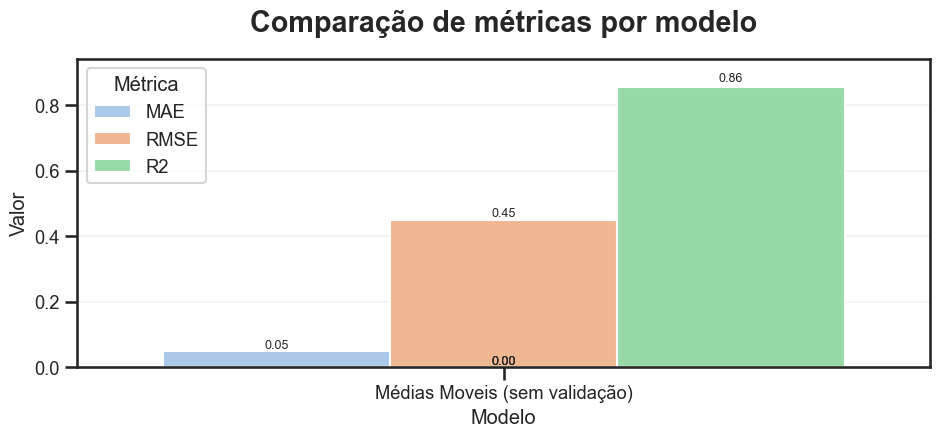

In [65]:
metrics_to_plot = ['MAE','RMSE','R2']

# Transformar para formato longo
df_melt = df_metrics.melt(id_vars='model', value_vars=metrics_to_plot,
                          var_name='Metric', value_name='Value')

plt.figure(figsize=(11,4))
ax = sns.barplot(x='model', y='Value', hue='Metric', data=df_melt)

# Adicionar valores em cima de cada barra
for p in ax.patches:
    height = p.get_height()
    ax.text(x=p.get_x() + p.get_width()/2., 
            y=height + 0.01*height,  # pequeno deslocamento acima da barra
            s=f'{height:.2f}', 
            ha='center', va='bottom', fontsize=9)

plt.title('Comparação de métricas por modelo')
plt.ylabel('Valor')
plt.xlabel('Modelo')
plt.ylim(0, df_melt['Value'].max()*1.1)  # Espaço para os valores acima das barras
plt.legend(title='Métrica')
plt.show()

### Efetuando a divisão correta de treino e teste

In [66]:
# Definir as datas de treino e teste
train_start = '2011-05-01'
train_end = '2013-10-31'
test_start = '2013-11-01'
test_end = '2014-06-30'

# Garantir que as datas estão no formato datetime
df_monthly['order_date_dt'] = pd.to_datetime(df_monthly['order_date_dt'])

# Criar DataFrame completo com todas as combinações (lojas, produtos, datas)
future_max_date = test_end  # Não prever além do teste
full_index = pd.MultiIndex.from_product(
    [listas_lojas, listas_produtos, pd.date_range(start=train_start, end=future_max_date, freq='M')],
    names=['name_store', 'name_product', 'order_date_dt']
)
df_full = pd.DataFrame(index=full_index).reset_index()

# Mesclar com dados reais e preencher missing com 0
df_merged = pd.merge(df_full, df_monthly, on=['name_store', 'name_product', 'order_date_dt'], how='left').fillna(0)

# Calcular a média móvel APENAS no conjunto de treino
window_size = 3
df_merged['rolling_mean'] = (
    df_merged[df_merged['order_date_dt'] <= train_end]  # Apenas treino
    .groupby(['name_store', 'name_product'])['order_qty']
    .transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
)

# Propagar a última média móvel para o período de teste
df_merged['previsao_demanda'] = df_merged.groupby(['name_store', 'name_product'])['rolling_mean'].ffill()
df_merged['previsao_demanda'] = np.ceil(df_merged['previsao_demanda']).fillna(0)  # Preencher NaNs com 0

# Remover coluna auxiliar
df_merged.drop(columns=['rolling_mean'], inplace=True)

# Avaliar apenas no período de teste
df_test = df_merged[(df_merged['order_date_dt'] >= test_start) & (df_merged['order_date_dt'] <= test_end)]
y_true = df_test['order_qty']
y_pred = df_test['previsao_demanda']

# Calcular métricas
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print("--- Métricas de Avaliação no Teste ---")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

--- Métricas de Avaliação no Teste ---
MAE: 0.09
MSE: 0.47
RMSE: 0.68
R²: 0.89


In [67]:
def view_prediction(lojas, produtos, df_merged):
    df_plot = df_merged[
        (df_merged['name_store'] == lojas) &
        (df_merged['name_product'] == produtos)
    ]
    plt.figure(figsize=(12, 6))
    
    # Treino
    treino = df_plot[df_plot['order_date_dt'] <= train_end]
    plt.plot(treino['order_date_dt'], treino['order_qty'], label='Treino (Real)', color='blue')
    
    # Teste (Real)
    teste_real = df_plot[(df_plot['order_date_dt'] >= test_start) & (df_plot['order_date_dt'] <= test_end)]
    plt.plot(teste_real['order_date_dt'], teste_real['order_qty'], label='Teste (Real)', color='green')
    
    # Previsão
    previsao = df_plot[df_plot['order_date_dt'] >= train_start]
    plt.plot(previsao['order_date_dt'], previsao['previsao_demanda'], label='Previsão', linestyle='--', color='red')
    
    plt.axvline(x=pd.to_datetime(train_end), color='gray', linestyle='--', label='Fim do Treino')
    plt.title(f'Previsão para {lojas} - {produtos}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [68]:
# lojas com vendas do produto reincidentemente mais vendido
lojas = set(df_merged[(df_merged['name_product'] =='Full-Finger Gloves, L') &
            (df_merged['order_qty'] > 0)]['name_store'])

@interact(lojas = lojas, produtos=listas_produtos)
def funcao_interativa(lojas, produtos):
    view_prediction(lojas, produtos, df_merged)

interactive(children=(Dropdown(description='lojas', options=('Hobby Store', 'Elemental Sporting Goods', 'Merca…

In [69]:
# Adicionando métricas ao store de metricas
df_metrics = pd.concat([df_metrics ,store_model_metrics('Médias Moveis (com validação)', y_true, y_pred)])

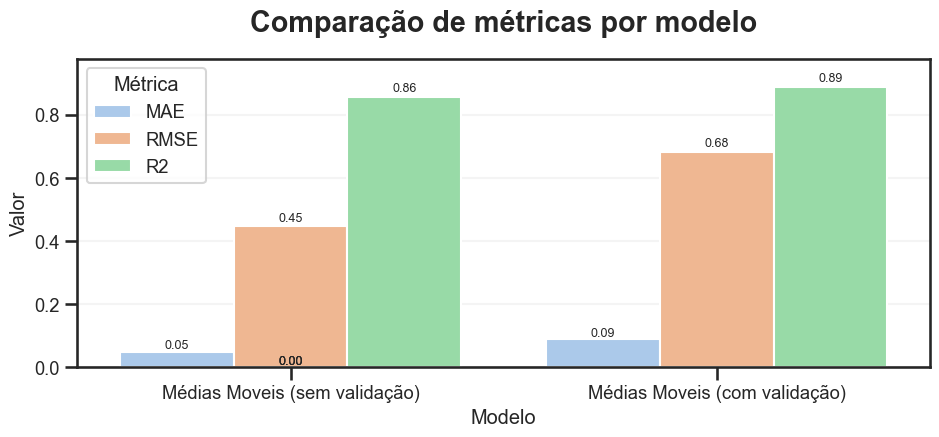

In [70]:
metrics_to_plot = ['MAE','RMSE','R2']

# Transformar para formato longo
df_melt = df_metrics.melt(id_vars='model', value_vars=metrics_to_plot,
                          var_name='Metric', value_name='Value')

plt.figure(figsize=(11,4))
ax = sns.barplot(x='model', y='Value', hue='Metric', data=df_melt)

# Adicionar valores em cima de cada barra
for p in ax.patches:
    height = p.get_height()
    ax.text(x=p.get_x() + p.get_width()/2., 
            y=height + 0.01*height,  # pequeno deslocamento acima da barra
            s=f'{height:.2f}', 
            ha='center', va='bottom', fontsize=9)

plt.title('Comparação de métricas por modelo')
plt.ylabel('Valor')
plt.xlabel('Modelo')
plt.ylim(0, df_melt['Value'].max()*1.1)  # Espaço para os valores acima das barras
plt.legend(title='Métrica')
plt.show()

### Selecionando um item comum para comparação entre modelos

In [71]:
df_filtered = df_merged[df_merged['name_product'] == 'Water Bottle - 30 oz.']
print(f'''
Quantidade de linhas: {len(df_filtered)}
Quantidade de produtos: {df_filtered.name_product.nunique()}
Quantidade de lojas: {df_filtered.name_store.nunique()}
''')
df_filtered.head()


Quantidade de linhas: 24092
Quantidade de produtos: 1
Quantidade de lojas: 634



,name_store,name_product,order_date_dt,order_qty,previsao_demanda
1558,Fitness Hotel,Water Bottle - 30 oz.,2011-05-31,0.00,0.00
1559,Fitness Hotel,Water Bottle - 30 oz.,2011-06-30,0.00,0.00
1560,Fitness Hotel,Water Bottle - 30 oz.,2011-07-31,0.00,0.00
1561,Fitness Hotel,Water Bottle - 30 oz.,2011-08-31,0.00,0.00
1562,Fitness Hotel,Water Bottle - 30 oz.,2011-09-30,0.00,0.00


In [72]:
# Calcular a média móvel APENAS no conjunto de treino
window_size = 3
df_filtered['rolling_mean'] = (
    df_filtered[df_filtered['order_date_dt'] <= train_end] 
    .groupby(['name_store', 'name_product'])['order_qty']
    .transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
)

# Propagar a última média móvel para o período de teste
df_filtered['previsao_demanda'] = df_filtered.groupby(['name_store', 'name_product'])['rolling_mean'].ffill()
df_filtered['previsao_demanda'] = np.ceil(df_filtered['previsao_demanda']).fillna(0)  # Preencher NaNs com 0

# Remover coluna auxiliar
df_filtered.drop(columns=['rolling_mean'], inplace=True)

# Avaliar apenas no período de teste
df_test = df_filtered[(df_filtered['order_date_dt'] >= test_start) & (df_filtered['order_date_dt'] <= test_end)]
y_true = df_test['order_qty']
y_pred = df_test['previsao_demanda']

# Calcular métricas
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print("--- Métricas de Avaliação no Teste ---")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

--- Métricas de Avaliação no Teste ---
MAE: 0.60
MSE: 15.20
RMSE: 3.90
R²: 0.93


In [73]:
# lojas com vendas do produto reincidentemente mais vendido
lojas = set(df_filtered[(df_filtered['name_product'] =="Water Bottle - 30 oz.") &
            (df_filtered['order_qty'] > 0)]['name_store'])

@interact(lojas = lojas, produtos="Water Bottle - 30 oz.")
def funcao_interativa(lojas, produtos):
    view_prediction(lojas, produtos, df_filtered)

interactive(children=(Dropdown(description='lojas', options=('South Bike Company', 'Twelfth Bike Store', 'Pain…

# SARIMAX

[Documentação SARIMAX](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html)

In [74]:
# Range de datas
train_start = '2011-05-01'
train_end = '2013-10-31'
test_start = '2013-11-01'
test_end = '2014-06-30'

In [75]:
# Criar DataFrame completo com todas as combinações somente para o item 'Water Bottle - 30 oz.'
future_max_date = test_end
full_index = pd.MultiIndex.from_product(
    [listas_lojas, ['Water Bottle - 30 oz.'], pd.date_range(start=train_start, end=future_max_date, freq='M')],
    names=['name_store', 'name_product', 'order_date_dt']
)
df_sarimax = pd.DataFrame(index=full_index).reset_index()
df_sarimax.head()

,name_store,name_product,order_date_dt
0,Fitness Hotel,Water Bottle - 30 oz.,2011-05-31
1,Fitness Hotel,Water Bottle - 30 oz.,2011-06-30
2,Fitness Hotel,Water Bottle - 30 oz.,2011-07-31
3,Fitness Hotel,Water Bottle - 30 oz.,2011-08-31
4,Fitness Hotel,Water Bottle - 30 oz.,2011-09-30


In [76]:
# Mesclar com dados reais
df_monthly_filtered = df_monthly[df_monthly['name_product'] == 'Water Bottle - 30 oz.']
df_sarimax = pd.merge(
    df_sarimax,
    df_monthly_filtered,
    on=['name_store', 'name_product', 'order_date_dt'],
    how='left'
).fillna(0)
print(f'''
Quantidade de linhas: {len(df_sarimax)}
Quantidade de produtos: {df_sarimax.name_product.nunique()}
Quantidade de lojas: {df_sarimax.name_store.nunique()}
''')
df_sarimax['previsao_sarimax'] = np.nan
df_sarimax.head()


Quantidade de linhas: 24092
Quantidade de produtos: 1
Quantidade de lojas: 634



,name_store,name_product,order_date_dt,order_qty,previsao_sarimax
0,Fitness Hotel,Water Bottle - 30 oz.,2011-05-31,0.00,NaN
1,Fitness Hotel,Water Bottle - 30 oz.,2011-06-30,0.00,NaN
2,Fitness Hotel,Water Bottle - 30 oz.,2011-07-31,0.00,NaN
3,Fitness Hotel,Water Bottle - 30 oz.,2011-08-31,0.00,NaN
4,Fitness Hotel,Water Bottle - 30 oz.,2011-09-30,0.00,NaN


In [ ]:
#Lista para armazenar métricas por loja
metrics_list = []

# Iterar sobre cada loja
for store in df_sarimax['name_store'].unique():
    # Filtrar dados para a loja específica
    store_data = df_sarimax[df_sarimax['name_store'] == store].copy()
    
    # Separar dados de treino e teste
    train_data = store_data[(store_data['order_date_dt'] >= train_start) & 
                           (store_data['order_date_dt'] <= train_end)]
    test_data = store_data[(store_data['order_date_dt'] >= test_start) & 
                          (store_data['order_date_dt'] <= test_end)]
    
    # Verificar se há dados suficientes para treino
    if len(train_data) < 12:
        print(f"Dados insuficientes para {store}. Pulando...")
        continue
    
    try:
        # Treinar modelo SARIMAX
        modelo = SARIMAX(
            train_data['order_qty'],
            order=(1, 1, 1),  # Parâmetros mais simples para melhor convergência
            seasonal_order=(0, 1, 1, 12),
            trend='n',
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        
        modelo_fit = modelo.fit(disp=False, maxiter=200)
        
        # Fazer previsões para o período de teste
        previsoes = modelo_fit.get_forecast(steps=len(test_data))
        previsoes_values = previsoes.predicted_mean
        
        # Atualizar previsões no DataFrame
        test_indices = test_data.index
        df_sarimax.loc[test_indices, 'previsao_sarimax'] = previsoes_values.values
        
        # Calcular métricas para esta loja
        y_true = test_data['order_qty'].values
        y_pred = previsoes_values.values
        
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)
        
        metrics_list.append({
            'store': store,
            'mae': mae,
            'mse': mse,
            'rmse': rmse,
            'r2': r2
        })
        
        print(f"Modelo treinado com sucesso para {store}")
        
    except Exception as e:
        print(f"Erro ao treinar SARIMAX para {store}: {str(e)}")
        continue

In [78]:
# Preencher previsões não calculadas com 0
df_sarimax['previsao_sarimax'] = df_sarimax['previsao_sarimax'].fillna(0)

# Avaliar apenas no período de teste
df_test = df_sarimax[(df_sarimax['order_date_dt'] >= test_start) & 
                    (df_sarimax['order_date_dt'] <= test_end)]
y_true = df_test['order_qty']
y_pred = df_test['previsao_sarimax']

# Calcular métricas
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print("--- Métricas de Avaliação do Modelo SARIMAX (Todas as Lojas) ---")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

--- Métricas de Avaliação do Modelo SARIMAX (Todas as Lojas) ---
MAE: 0.70
MSE: 33.60
RMSE: 5.80
R²: 0.84


In [79]:
df_metrics = pd.concat([df_metrics ,store_model_metrics('SARIMAX Total', y_true, y_pred)])

In [80]:
df_metrics.head()

,model,MAE,MSE,RMSE,R2
0,Médias Moveis (sem validação),0.05,0.20,0.45,0.86
0,Médias Moveis (com validação),0.09,0.47,0.68,0.89
0,SARIMAX Total,0.70,33.60,5.80,0.84


In [81]:
if metrics_list:
    avg_mae = np.mean([m['mae'] for m in metrics_list])
    avg_mse = np.mean([m['mse'] for m in metrics_list])
    avg_rmse = np.mean([m['rmse'] for m in metrics_list])
    avg_r2 = np.mean([m['r2'] for m in metrics_list])
    
    # Criar manualmente um DataFrame para as métricas médias
    df_avg_metrics = pd.DataFrame({
        'model': ['SARIMAX Média por Loja'],
        'MAE': [avg_mae],
        'MSE': [avg_mse],
        'RMSE': [avg_rmse],
        'R2': [avg_r2]
    })
    
    # Concatenar com o DataFrame existente
    df_metrics = pd.concat([df_metrics, df_avg_metrics], ignore_index=True)
    
    print("--- Métricas de Avaliação do Modelo SARIMAX (Médias por Loja) ---")
    print(f"MAE: {avg_mae:.2f}")
    print(f"MSE: {avg_mse:.2f}")
    print(f"RMSE: {avg_rmse:.2f}")
    print(f"R²: {avg_r2:.2f}")

--- Métricas de Avaliação do Modelo SARIMAX (Médias por Loja) ---
MAE: 0.70
MSE: 33.60
RMSE: 0.92
R²: 0.04


In [82]:
df_metrics.head()

,model,MAE,MSE,RMSE,R2
0,Médias Moveis (sem validação),0.05,0.20,0.45,0.86
1,Médias Moveis (com validação),0.09,0.47,0.68,0.89
2,SARIMAX Total,0.70,33.60,5.80,0.84
3,SARIMAX Média por Loja,0.70,33.60,0.92,0.04


In [83]:
def view_sarimax_prediction(loja, df_sarimax):
    df_plot = df_sarimax[df_sarimax['name_store'] == loja].copy()
    
    plt.figure(figsize=(12, 6))
    
    # Dados reais de treino
    treino = df_plot[df_plot['order_date_dt'] <= train_end]
    plt.plot(treino['order_date_dt'], treino['order_qty'], label='Treino (Real)', color='blue')
    
    # Dados reais de teste
    teste_real = df_plot[(df_plot['order_date_dt'] >= test_start) & (df_plot['order_date_dt'] <= test_end)]
    plt.plot(teste_real['order_date_dt'], teste_real['order_qty'], label='Teste (Real)', color='green')
    
    # Previsão SARIMAX
    previsao = df_plot[df_plot['order_date_dt'] >= test_start]
    plt.plot(previsao['order_date_dt'], previsao['previsao_sarimax'], label='Previsão SARIMAX', linestyle='--', color='red')
    
    plt.axvline(x=pd.to_datetime(train_end), color='gray', linestyle='--', label='Fim do Treino')
    plt.title(f'Previsão SARIMAX para {loja} - Water Bottle - 30 oz.')
    plt.xlabel('Data')
    plt.ylabel('Quantidade Vendida')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [84]:
# Loja com vendas do produto
lojas_com_vendas = set(df_sarimax[(df_sarimax['name_product'] == "Water Bottle - 30 oz.") &
                                 (df_sarimax['order_qty'] > 0)]['name_store'])

# Criar widget interativo
@interact(loja=lojas_com_vendas)
def funcao_interativa_sarimax(loja):
    view_sarimax_prediction(loja, df_sarimax)

interactive(children=(Dropdown(description='loja', options=('South Bike Company', 'Twelfth Bike Store', 'Paint…

In [85]:
df_metrics.iloc[2:]

,model,MAE,MSE,RMSE,R2
2,SARIMAX Total,0.70,33.60,5.80,0.84
3,SARIMAX Média por Loja,0.70,33.60,0.92,0.04


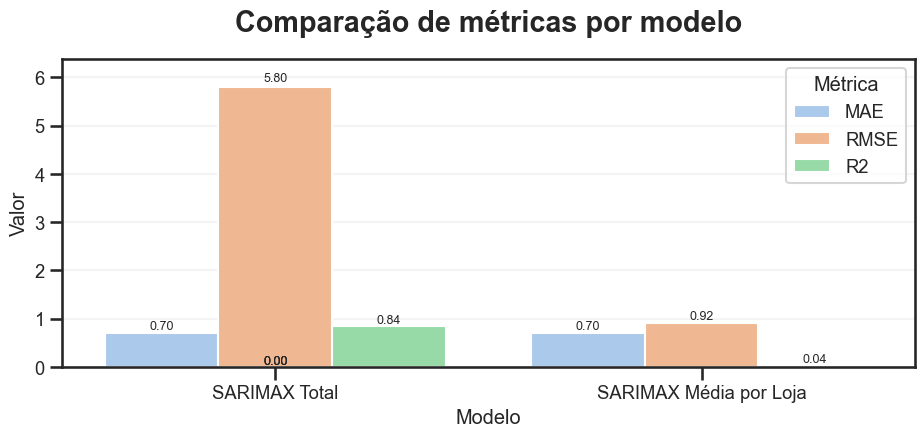

In [86]:
metrics_to_plot = ['MAE','RMSE','R2']

# Transformar para formato longo
df_melt = df_metrics.iloc[2:].melt(id_vars='model', value_vars=metrics_to_plot,
                          var_name='Metric', value_name='Value')

plt.figure(figsize=(11,4))
ax = sns.barplot(x='model', y='Value', hue='Metric', data=df_melt)

# Adicionar valores em cima de cada barra
for p in ax.patches:
    height = p.get_height()
    ax.text(x=p.get_x() + p.get_width()/2., 
            y=height + 0.01*height,  # pequeno deslocamento acima da barra
            s=f'{height:.2f}', 
            ha='center', va='bottom', fontsize=9)

plt.title('Comparação de métricas por modelo')
plt.ylabel('Valor')
plt.xlabel('Modelo')
plt.ylim(0, df_melt['Value'].max()*1.1)  # Espaço para os valores acima das barras
plt.legend(title='Métrica')
plt.show()

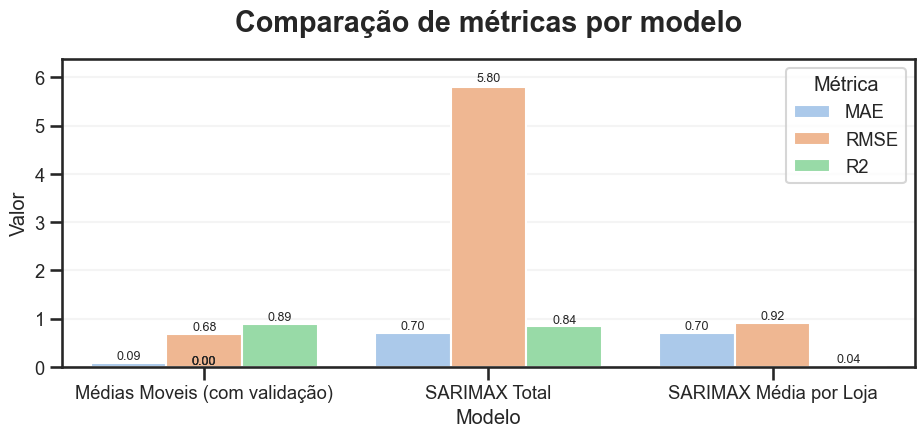

In [87]:
metrics_to_plot = ['MAE','RMSE','R2']

# Transformar para formato longo
df_melt = df_metrics.iloc[1:].melt(id_vars='model', value_vars=metrics_to_plot,
                          var_name='Metric', value_name='Value')

plt.figure(figsize=(11,4))
ax = sns.barplot(x='model', y='Value', hue='Metric', data=df_melt)

# Adicionar valores em cima de cada barra
for p in ax.patches:
    height = p.get_height()
    ax.text(x=p.get_x() + p.get_width()/2., 
            y=height + 0.01*height,  # pequeno deslocamento acima da barra
            s=f'{height:.2f}', 
            ha='center', va='bottom', fontsize=9)

plt.title('Comparação de métricas por modelo')
plt.ylabel('Valor')
plt.xlabel('Modelo')
plt.ylim(0, df_melt['Value'].max()*1.1)  # Espaço para os valores acima das barras
plt.legend(title='Métrica')
plt.show()

# PyTorch Forecasting

O `Temporal Fusion Transformer: TFT` é um modelo avançado para previsão de séries temporais que combina técnicas de Redes Neurais Recorrentes RNNs com mecanismos de atenção inspirados nos Transformers. Esse modelo é considerado próximo ao estado da arte para séries temporais devido à sua capacidade de lidar com múltiplas features variáveis estáticas, conhecidas e desconhecidas ao longo do tempo e gerar previsões em diferentes granularidades, que no contexto da Adventure Works será utilizada a granularidade de `produto` e `loja`.

O TFT utiliza atenção temporal e de variáveis para identificar automaticamente quais períodos históricos e quais features são mais relevantes para a previsão, permitindo capturar padrões sazonais, tendências e interações complexas entre variáveis. Além disso, ele permite previsão multivariada, ou seja, pode prever várias variáveis de interesse ao mesmo tempo.

* [Documentação PyTorch Forecasting](https://pytorch-forecasting.readthedocs.io/en/v1.4.0/api/pytorch_forecasting.models.temporal_fusion_transformer._tft.TemporalFusionTransformer.html)
* [Link Paper Temporal Fusion Transformer ](https://arxiv.org/pdf/1912.09363)

Infelizmente, no dia da entrega o modelo deixou de funcionar devido a incompatibilidades de pacotes.

O código referente ao modelo que funcionou por dias está no arquivo `models_forecasting_aw.py`

O modelo em si apresentou ótimo desempenho em todos os testes, mesmo utilizando poucas camadas ocultas, head-atentions e um treinamento curto (poucas epochs) era capaz de passar pelos testes com um R2 alto e MAE/RMSE baixo, demonstrando todo o potencial.

Além de fornecer soluções prontas para validação do modelo, onde era possivel inferir quais as feature mais relevantes, gerar um intervalo de confiança entre outros aspectos.

In [88]:
# model = ForecastingModel(df_sarimax.drop('previsao_sarimax', axis=1), epochs=2)

In [89]:
# model.run_complete_pipeline()